# Explaining ANN (Classification) to identify depression

## Import all necessary libraries

Of the following imports, the most important libraries are: sklearn.neural_network and sklearn.metrics.

In [1]:
import joblib
import dice_ml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from alibi.explainers.ale import ALE, plot_ale

## Defining global variables

The following variables defined below can be modified according to the given approach.

In [2]:
## Global variable designated for data loading.
path_dataset = "Dataset_MO_ENG.csv"
path_dataset_qa = "Dataset_QA_ENG.csv"
path_dataset_qs = "Dataset_QS_ENG.csv"
path_dataset_qm = "Dataset_QM_ENG.csv"
path_dataset_qd = "Dataset_QD_ENG.csv"

## Global variables designated for threshold control.
positive_threshold = 0.01
negative_threshold = -0.01

## Global improvement variable of the neural network.
list_contr = [3, 4, 5, 14, 21, 24, 25, 26, 27, 29, 30, 32, 48, 49, 51, 54, 55, 58, 59, 60, 62, 63, 66, 68,
              70, 75, 78, 83, 85, 86, 87, 89, 90, 91, 94, 95, 96, 98, 100, 101]

## Anomadic question identification mode.
selection_mode = 2
regul_param_normal = 10.0 ** -np.arange(-2, 7)
regul_param_alpha = 10.0 ** -np.arange(0, 7)

## Defining private variables

The following variables defined below cannot be modified since they are an integral part of its operation.

In [3]:
## Private variables for the neural network by classification.
class_dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2}
target_names = ["Low", "Medium", "High"]

## Private variables for oversample.
random_state = 13
oversample = SMOTE(random_state=random_state)

## Private variables for neural network generation.
seed = 1

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [4]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     3. My friends or family have told me that I look different  \
0                                                    0            
1                                                    1            
2                                                    0            
3                                                    0            
4                                                    0            
..                                                 ...            
99                                                   1            
100                                                  0            
101                                                  1            
102                                                  0            
103                                                  0            

     4. When I think about the future it is difficult for me to imagine it clearly  \
0                                                    1                               
1                                                    1                               
2                                                    0                               
3                                                    1                               
4                                                    1                               
..                                                 ...                               
99                                                   0                               
100                                                  0                               
101                                                  1                               
102                                                  0                               
103                                                  0                               

     5. People around me often ask me how I feel  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   
..                                           ...   
99                                             0   
100                                            1   
101                                            1   
102                                            1   
103                                            0   

     6. I consid

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [5]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [6]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [7]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [9]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.4763355552829237,
  0.4513935101705999,
  0.46248242125951106,
  0.4691799342728135,
  0.4691799342728135,
  0.4691799342728135,
  0.4691799342728135],
 [0.006020651927912844,
  0.006020651927912844,
  0.09918844066715299,
  0.08068804784278276,
  0.09270871998125078,
  0.08309589200633044,
  0.08309589200633044,
  0.08309589200633044,
  0.08309589200633044])

We proceed to draw the learning curve graph according to the data obtained by the training.

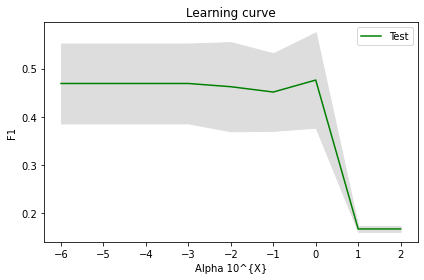

In [10]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [11]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.46703181808444966,
  0.45220030972352954,
  0.4405739461776614,
  0.4763355552829237,
  0.16659498207885304,
  0.16659498207885304],
 [0.006020651927912844,
  0.0700006268704352,
  0.09521251410308869,
  0.0887293445552907,
  0.09918844066715299,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

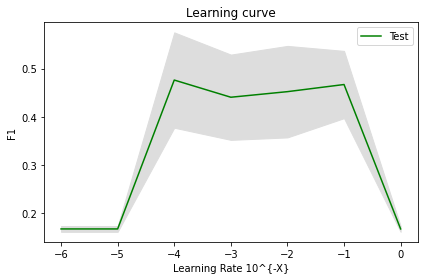

In [12]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [13]:
## The value of the alpha parameter is kept at 1 as well as the value of the seed of random_state at 77.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = 77)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1, hidden_layer_sizes=(10,),
              learning_rate_init=0.0001, max_iter=100000, random_state=77)

We safeguard the final generated model

In [14]:
joblib.dump(mlp,"model_depression.pkl")

['model_depression.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

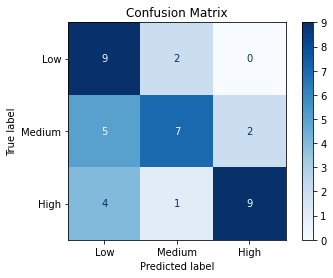

In [15]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [16]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 64.1025641025641 %

              precision    recall  f1-score   support

           0       0.50      0.82      0.62        11
           1       0.70      0.50      0.58        14
           2       0.82      0.64      0.72        14

    accuracy                           0.64        39
   macro avg       0.67      0.65      0.64        39
weighted avg       0.69      0.64      0.64        39



## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [17]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

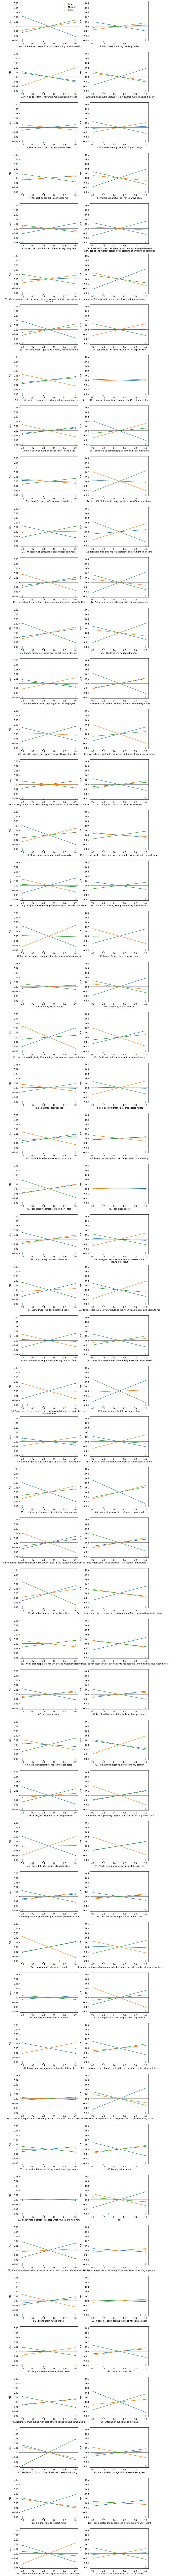

In [18]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 180});

## Neural network model improvement iterative process

From this moment, we proceed to improve the performance of the neural network to predict high depression.

## Iteration 1

The first iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [19]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of list of conflicting questions declared in global variables.
i = 0
for x in list_contr:
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1
    
    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     7. My hobbies are still important to me  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          0   
..                                       ...   
99                                         1   
100                                        1   
101                                        1   
102                                        1   
103                                        1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     9. If I had the chance, I would spend all day in my bed  \
0                                                    0         
1                                                    0         
2                                                    0         
3                                                    1         
4                                                    1         
..                                                 ...         
99                                                   0         
100                             

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [20]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [21]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [22]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [24]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.19322610764736,
  0.33584807349513235,
  0.4624614446441072,
  0.4712849740558719,
  0.48138800942206517,
  0.48138800942206517,
  0.48138800942206517,
  0.48138800942206517],
 [0.006020651927912844,
  0.06190163786344686,
  0.04574358771581292,
  0.08331624906294144,
  0.07035317262431248,
  0.086614802288128,
  0.086614802288128,
  0.086614802288128,
  0.086614802288128])

We proceed to draw the learning curve graph according to the data obtained by the training.

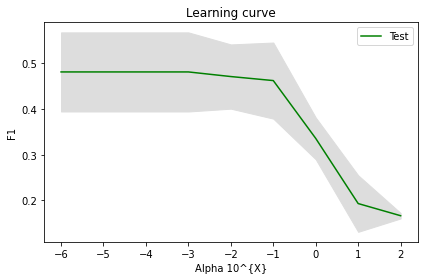

In [25]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [26]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.1632974910394265,
  0.4740513614352624,
  0.4483093256932267,
  0.4577127585177121,
  0.33584807349513235,
  0.16659498207885304,
  0.16659498207885304],
 [0.006619092595549127,
  0.14126534835534385,
  0.1542276089835744,
  0.11392529450516314,
  0.04574358771581292,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

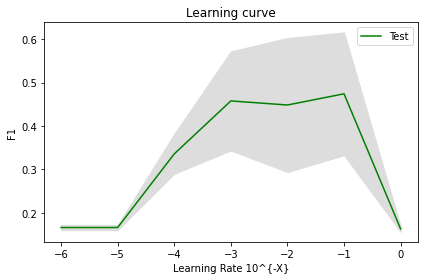

In [27]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [28]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [29]:
joblib.dump(mlp,"model_depression_i1.pkl")

['model_depression_i1.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

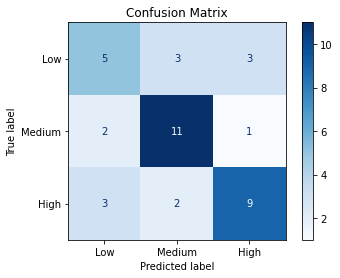

In [30]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [31]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 64.1025641025641 %

              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.69      0.79      0.73        14
           2       0.69      0.64      0.67        14

    accuracy                           0.64        39
   macro avg       0.63      0.63      0.63        39
weighted avg       0.64      0.64      0.64        39



In [32]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## The number of questions used in the iteration is retrieved.
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,14,21,24,25,26,27,29,30,32,48,49,51,54,5...        64.102564   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0          0.5  0.454545     0.47619         11       0.6875  0.785714   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.733333         14     0.692308  0.642857    0.666667         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [33]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

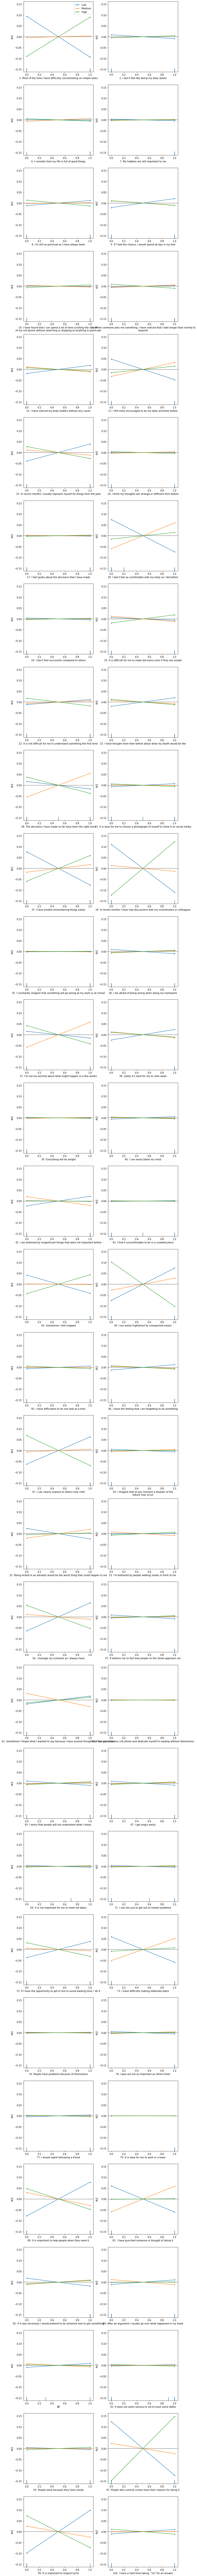

In [34]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 150});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [35]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0         1  -0.188073    0.180665            NA             NA          NA   
1         2  -0.017648    0.009065            NA             NA          NA   
2         6  -0.001497   -0.011459            NA             NA          NA   
3         7  -0.007423    0.002598            NA             NA          NA   
4         8   0.023104   -0.026986            NA             NA          NA   
..      ...        ...         ...           ...            ...         ...   
57       92   0.006494   -0.007989            NA             NA          NA   
58       93  -0.008606    0.011228            NA             NA          NA   
59       97  -0.247825    0.294782            NA             NA          NA   
60       99   0.196822   -0.146336            NA             NA          NA   
61      102   0.020829   -0.022950            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
..          ...  
57           NA  
58           NA  
59           NA  
60           NA  
61           NA  

[62 rows x 7 columns]

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [36]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0         1  -0.188073    0.180665             0              1          NA   
1         2  -0.017648    0.009065             0             NA          NA   
2         6  -0.001497   -0.011459            NA              0          NA   
3         7  -0.007423    0.002598            NA             NA          NA   
4         8   0.023104   -0.026986             1              0          NA   
..      ...        ...         ...           ...            ...         ...   
57       92   0.006494   -0.007989            NA             NA          NA   
58       93  -0.008606    0.011228            NA              1          NA   
59       97  -0.247825    0.294782             0              1          NA   
60       99   0.196822   -0.146336             1              0          NA   
61      102   0.020829   -0.022950             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
..          ...  
57           NA  
58           NA  
59           NA  
60           NA  
61           NA  

[62 rows x 7 columns]

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [37]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        7             Mis aficiones siguen siendo importante   0
4        8       Sigo siendo tan puntual como siempre he sido   0
..     ...                                                ...  ..
57      92            No me parece grave tener algunas deudas   1
58      93             La gente roba porque tiene necesidades   1
59      97  La gente que comete crímenes tiene sus razones...   1
60      99                  Es importante respetar los turnos   0
61     102   Me cuesta trabajo aceptar un “no” como respuesta   1

[62 rows x 3 columns]

We proceed to identify the anomadic questions present in the model present in this iteration.

In [38]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0         1  -0.188073    0.180665             0              1           0   
1         2  -0.017648    0.009065             0             NA           0   
2         6  -0.001497   -0.011459            NA              0          NA   
3         7  -0.007423    0.002598            NA             NA          NA   
4         8   0.023104   -0.026986             1              0           0   
..      ...        ...         ...           ...            ...         ...   
57       92   0.006494   -0.007989            NA             NA          NA   
58       93  -0.008606    0.011228            NA              1          NA   
59       97  -0.247825    0.294782             0              1           0   
60       99   0.196822   -0.146336             1              0           0   
61      102   0.020829   -0.022950             1              0           1   

   Anomaly High  
0             0  
1            NA  
2             0  
3            NA  
4             0  
..          ...  
57           NA  
58            0  
59            0  
60            0  
61            1  

[62 rows x 7 columns]

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [39]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[9, 11, 12, 15, 23, 38, 44, 45, 46, 72, 102]

## Iteration 2

The second iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [40]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     7. My hobbies are still important to me  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          0   
..                                       ...   
99                                         1   
100                                        1   
101                                        1   
102                                        1   
103                                        1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                  

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [41]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [42]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [43]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [45]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.15999999999999998,
  0.24206284943127052,
  0.30571779236432206,
  0.28391696838958497,
  0.2849352225812138,
  0.2849352225812138,
  0.2849352225812138,
  0.2849352225812138,
  0.2849352225812138],
 [0.005443310539518168,
  0.05412997390137115,
  0.07837114850112376,
  0.0760679130846169,
  0.07647789235276374,
  0.07647789235276374,
  0.07647789235276374,
  0.07647789235276374,
  0.07647789235276374])

We proceed to draw the learning curve graph according to the data obtained by the training.

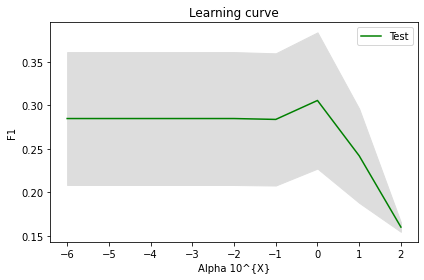

In [46]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [47]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.20002265570686623,
  0.4314402264402264,
  0.4498720090825354,
  0.4378194102652307,
  0.30571779236432206,
  0.16659498207885304,
  0.16659498207885304],
 [0.03854518308236841,
  0.13062146376380732,
  0.13455453846003146,
  0.1275674740375547,
  0.07837114850112376,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

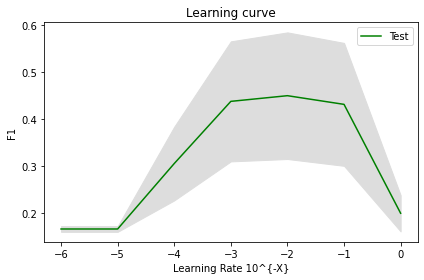

In [48]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [49]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [50]:
joblib.dump(mlp,"model_depression_i2.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

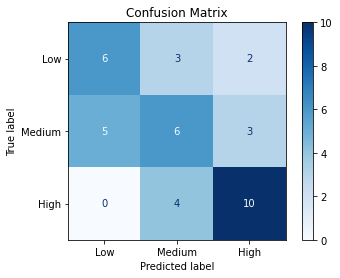

In [51]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [52]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 56.41025641025641 %

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.46      0.43      0.44        14
           2       0.67      0.71      0.69        14

    accuracy                           0.56        39
   macro avg       0.56      0.56      0.56        39
weighted avg       0.56      0.56      0.56        39



In [53]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,9,11,12,14,15,21,23,24,25,26,27,29,30,32...        56.410256   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.545455  0.545455    0.545455         11     0.461538  0.428571   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.444444         14     0.666667  0.714286    0.689655         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [54]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

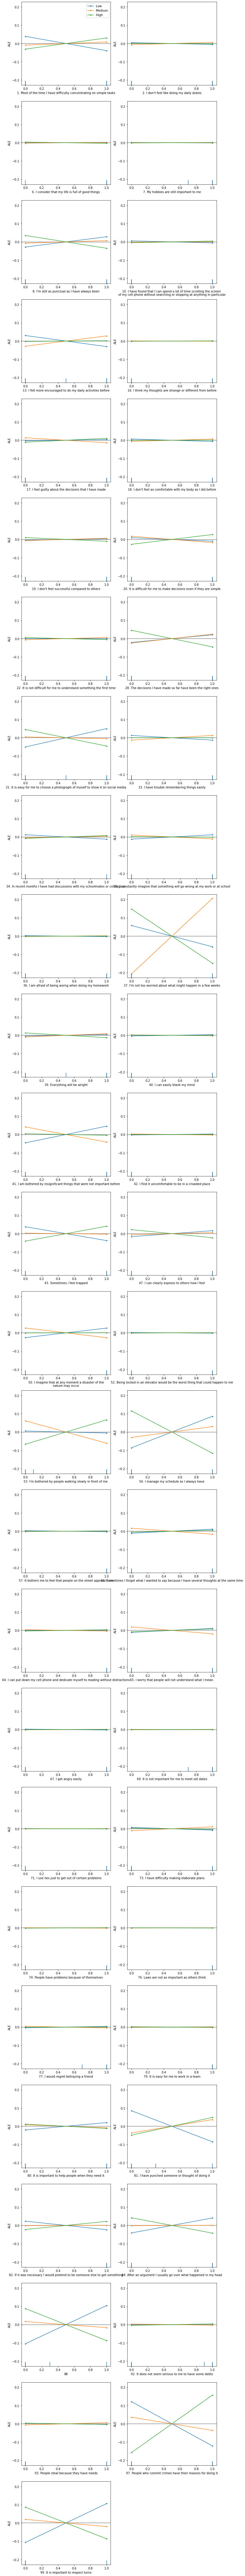

In [55]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 120});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [56]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.078007    0.060910            NA             NA          NA   
1          2  -0.009548   -0.002863            NA             NA          NA   
2          6   0.004662   -0.006732            NA             NA          NA   
3          7  -0.002550    0.002728            NA             NA          NA   
4          8   0.056086   -0.069883            NA             NA          NA   
5         10  -0.011161    0.009315            NA             NA          NA   
6         13  -0.060551    0.004189            NA             NA          NA   
7         16  -0.000957    0.002491            NA             NA          NA   
8         17   0.006024    0.021221            NA             NA          NA   
9         18  -0.013840    0.001035            NA             NA          NA   
10        19   0.007562   -0.020408            NA             NA          NA   
11        20  -0.018922    0.053429            NA             NA          NA   
12        22  -0.000985   -0.011379            NA             NA          NA   
13        28   0.042039   -0.090640            NA             NA          NA   
14        31   0.100081   -0.090169            NA             NA          NA   
15        33  -0.025636   -0.000395            NA             NA          NA   
16        34  -0.024138    0.015840            NA             NA          NA   
17        35   0.024024   -0.002917            NA             NA          NA   
18        36  -0.005089    0.001344            NA             NA          NA   
19        37  -0.116651   -0.297465            NA             NA          NA   
20        39   0.007830   -0.025644            NA             NA          NA   
21        40   0.007482   -0.002813            NA             NA          NA   
22        41   0.090997   -0.008499            NA             NA          NA   
23        42   0.005507    0.000417            NA             NA          NA   
24        43  -0.075720    0.081373            NA             NA          NA   
25        47   0.032606   -0.044468            NA             NA          NA   
26        50   0.052174    0.000956            NA             NA          NA   
27        52  -0.003530    0.001521            NA             NA          NA   
28        53  -0.010847    0.133234            NA             NA          NA   
29        56   0.172758   -0.232054            NA             NA          NA   
30        57  -0.005832    0.003360            NA             NA          NA   
31        61   0.022238    0.010717            NA             NA          NA   
32        64   0.000651    0.007177            NA             NA          NA   
33        65   0.021270    0.016541            NA             NA          NA   
34        67  -0.004709    0.001697            NA             NA          NA   
35        69  -0.001326    0.002261            NA             NA          NA   
36        71  -0.001712    0.000001            NA             NA          NA   
37        73  -0.015070   -0.006194            NA             NA          NA   
38        74  -0.000797    0.002747            NA             NA          NA   
39        76  -0.000559   -0.000642            NA             NA          NA   
40        77   0.007391    0.001862            NA             NA          NA   
41        79   0.003297   -0.003971            NA             NA          NA   
42        80   0.040535   -0.023198            NA             NA          NA   
43        81  -0.170393    0.097061            NA             NA          NA   
44        82  -0.046482    0.044328            NA             NA          NA   
45        84   0.081859   -0.084221            NA             NA          NA   
46        88   0.208674   -0.175313            NA             NA          NA   
47        92  -0.002075    0.008080            NA             NA          NA   
48        93  -0.005819   -0.006279            NA             NA          NA   
49  

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [57]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.078007    0.060910             0              1          NA   
1          2  -0.009548   -0.002863            NA             NA          NA   
2          6   0.004662   -0.006732            NA             NA          NA   
3          7  -0.002550    0.002728            NA             NA          NA   
4          8   0.056086   -0.069883             1              0          NA   
5         10  -0.011161    0.009315             0             NA          NA   
6         13  -0.060551    0.004189             0             NA          NA   
7         16  -0.000957    0.002491            NA             NA          NA   
8         17   0.006024    0.021221            NA              1          NA   
9         18  -0.013840    0.001035             0             NA          NA   
10        19   0.007562   -0.020408            NA              0          NA   
11        20  -0.018922    0.053429             0              1          NA   
12        22  -0.000985   -0.011379            NA              0          NA   
13        28   0.042039   -0.090640             1              0          NA   
14        31   0.100081   -0.090169             1              0          NA   
15        33  -0.025636   -0.000395             0             NA          NA   
16        34  -0.024138    0.015840             0              1          NA   
17        35   0.024024   -0.002917             1             NA          NA   
18        36  -0.005089    0.001344            NA             NA          NA   
19        37  -0.116651   -0.297465             0              0          NA   
20        39   0.007830   -0.025644            NA              0          NA   
21        40   0.007482   -0.002813            NA             NA          NA   
22        41   0.090997   -0.008499             1             NA          NA   
23        42   0.005507    0.000417            NA             NA          NA   
24        43  -0.075720    0.081373             0              1          NA   
25        47   0.032606   -0.044468             1              0          NA   
26        50   0.052174    0.000956             1             NA          NA   
27        52  -0.003530    0.001521            NA             NA          NA   
28        53  -0.010847    0.133234             0              1          NA   
29        56   0.172758   -0.232054             1              0          NA   
30        57  -0.005832    0.003360            NA             NA          NA   
31        61   0.022238    0.010717             1              1          NA   
32        64   0.000651    0.007177            NA             NA          NA   
33        65   0.021270    0.016541             1              1          NA   
34        67  -0.004709    0.001697            NA             NA          NA   
35        69  -0.001326    0.002261            NA             NA          NA   
36        71  -0.001712    0.000001            NA             NA          NA   
37        73  -0.015070   -0.006194             0             NA          NA   
38        74  -0.000797    0.002747            NA             NA          NA   
39        76  -0.000559   -0.000642            NA             NA          NA   
40        77   0.007391    0.001862            NA             NA          NA   
41        79   0.003297   -0.003971            NA             NA          NA   
42        80   0.040535   -0.023198             1              0          NA   
43        81  -0.170393    0.097061             0              1          NA   
44        82  -0.046482    0.044328             0              1          NA   
45        84   0.081859   -0.084221             1              0          NA   
46        88   0.208674   -0.175313             1              0          NA   
47        92  -0.002075    0.008080            NA             NA          NA   
48        93  -0.005819   -0.006279            NA             NA          NA   
49  

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [58]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        7             Mis aficiones siguen siendo importante   0
4        8       Sigo siendo tan puntual como siempre he sido   0
5       10  Me he dado cuenta de que puedo pasar mucho tie...   1
6       13  Antes me sentía más animado para hacer mis act...   1
7       16  Creo que mis pensamientos son extraños o disti...   1
8       17    Siento culpa sobre las decisiones que he tomado   1
9       18  No me siento tan cómodo con mi cuerpo como me ...   1
10      19       Comparado con los demás no me siento exitoso   1
11      20  Me resulta complicado poder tomar decisiones a...   1
12      22      No se me dificulta entender algo a la primera   0
13      28  Las decisiones que he tomado hasta hoy han sid...   0
14      31  Me resulta fácil escoger una fotografía propia...   0
15      33  Tengo dificultades para recordar cosas con fac...   1
16      34  . En los últimos meses he tenido discusiones c...   1
17      35  Constantemente imagino que algo saldrá mal en ...   1
18      36    Tengo miedo de equivocarme al hacer mis deberes   1
19      37  No me preocupa tanto lo que pueda pasar en una...   0
20      39                                   Todo saldrá bien   0
21      40       Puedo poner mi mente en blanco con facilidad   0
22      41  Me molestan cosas insignificantes que antes no...   1
23      42  Me resulta incomodo estar en un espacio donde ...   1
24      43                         A veces me siento atrapado   1
25      47  Puedo expresarle con claridad a los otros cómo...   0
26      50  Imagino que en cualquier momento puede suceder...   1
27      52  Quedarme encerrado en un elevador sería de lo ...   1
28      53  Me molesta la gente que camina lento por la ca...   1
29      56       Manejo mis horarios como siempre lo he hecho   0
30      57  Me incomoda sentir que la gente en la calle se...   1
31      61  A veces olvido lo que quería decir porque teng...   1
32      64  Puedo dejar el celular y dedicarme a leer sin ...   0
33      65  Me preocupa que la gente no entienda lo que qu...   1
34      67                             Me enojo con facilidad   1
35      69  No me resulta importante cumplir con fechas es...   1
36      71  Utilizo las mentiras sólo para salir de alguno...   1
37      73    Tengo dificultades para hacer planes elaborados   1
38      74              La gente tiene problemas por su culpa   1
39      76  Las leyes no son tan importantes como otros creen   1
40      77             Me lamentaría al traicionar a un amigo   0
41      79                  Se me facilita trabajar en equipo   0
42      80  Es importante ayudar a la gente cuando lo nece...   0
43      81      He golpeado a alguien o he pensado en hacerlo   1
44      82  Si fuera necesario me haría pasar por alguien ...   1
45      84  Después de una discusión suelo repasar en mi c...   0
46      88  A veces la gente necesita de la fuerza física ...   1
47      92            No me parece grave tener algunas deudas   1
48      93             La gente roba porque tiene necesidades   1
49      97  La gente que comete crímenes tiene sus razones...   1
50      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [59]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.078007    0.060910             0              1           0   
1          2  -0.009548   -0.002863            NA             NA          NA   
2          6   0.004662   -0.006732            NA             NA          NA   
3          7  -0.002550    0.002728            NA             NA          NA   
4          8   0.056086   -0.069883             1              0           0   
5         10  -0.011161    0.009315             0             NA           0   
6         13  -0.060551    0.004189             0             NA           0   
7         16  -0.000957    0.002491            NA             NA          NA   
8         17   0.006024    0.021221            NA              1          NA   
9         18  -0.013840    0.001035             0             NA           0   
10        19   0.007562   -0.020408            NA              0          NA   
11        20  -0.018922    0.053429             0              1           0   
12        22  -0.000985   -0.011379            NA              0          NA   
13        28   0.042039   -0.090640             1              0           0   
14        31   0.100081   -0.090169             1              0           0   
15        33  -0.025636   -0.000395             0             NA           0   
16        34  -0.024138    0.015840             0              1           0   
17        35   0.024024   -0.002917             1             NA           1   
18        36  -0.005089    0.001344            NA             NA          NA   
19        37  -0.116651   -0.297465             0              0           1   
20        39   0.007830   -0.025644            NA              0          NA   
21        40   0.007482   -0.002813            NA             NA          NA   
22        41   0.090997   -0.008499             1             NA           1   
23        42   0.005507    0.000417            NA             NA          NA   
24        43  -0.075720    0.081373             0              1           0   
25        47   0.032606   -0.044468             1              0           0   
26        50   0.052174    0.000956             1             NA           1   
27        52  -0.003530    0.001521            NA             NA          NA   
28        53  -0.010847    0.133234             0              1           0   
29        56   0.172758   -0.232054             1              0           0   
30        57  -0.005832    0.003360            NA             NA          NA   
31        61   0.022238    0.010717             1              1           1   
32        64   0.000651    0.007177            NA             NA          NA   
33        65   0.021270    0.016541             1              1           1   
34        67  -0.004709    0.001697            NA             NA          NA   
35        69  -0.001326    0.002261            NA             NA          NA   
36        71  -0.001712    0.000001            NA             NA          NA   
37        73  -0.015070   -0.006194             0             NA           0   
38        74  -0.000797    0.002747            NA             NA          NA   
39        76  -0.000559   -0.000642            NA             NA          NA   
40        77   0.007391    0.001862            NA             NA          NA   
41        79   0.003297   -0.003971            NA             NA          NA   
42        80   0.040535   -0.023198             1              0           0   
43        81  -0.170393    0.097061             0              1           0   
44        82  -0.046482    0.044328             0              1           0   
45        84   0.081859   -0.084221             1              0           0   
46        88   0.208674   -0.175313             1              0           1   
47        92  -0.002075    0.008080            NA             NA          NA   
48        93  -0.005819   -0.006279            NA             NA          NA   
49  

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [60]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[19, 88]

## Iteration 3

The third iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [61]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     7. My hobbies are still important to me  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          0   
..                                       ...   
99                                         1   
100                                        1   
101                                        1   
102                                        1   
103                                        1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                  

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [62]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [63]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [64]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [66]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16329749103942653,
  0.18026037160631153,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.006619092595549127,
  0.028021044395542195,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

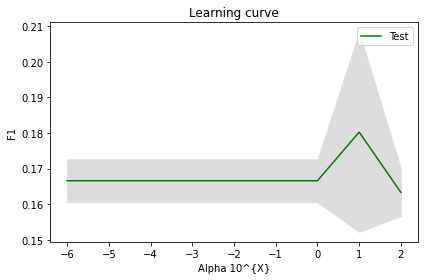

In [67]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [68]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.18578597030209934,
  0.4657540716364246,
  0.4830854439677969,
  0.4718491009048285,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.03912815731541059,
  0.08131191266979419,
  0.07748179685218214,
  0.08743387745396868,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

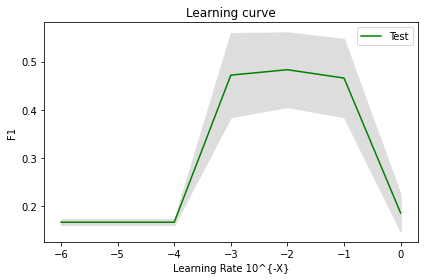

In [69]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [70]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [71]:
joblib.dump(mlp,"model_depression_i3.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

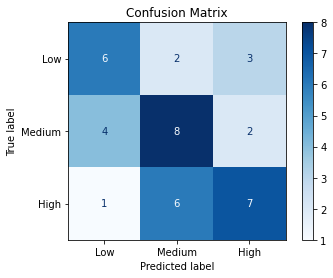

In [72]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [73]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 53.84615384615385 %

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.50      0.57      0.53        14
           2       0.58      0.50      0.54        14

    accuracy                           0.54        39
   macro avg       0.54      0.54      0.54        39
weighted avg       0.54      0.54      0.54        39



In [74]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,9,11,12,14,15,19,21,23,24,25,26,27,29,30...        53.846154   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.545455  0.545455    0.545455         11          0.5  0.571429   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.533333         14     0.583333       0.5    0.538462         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [75]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

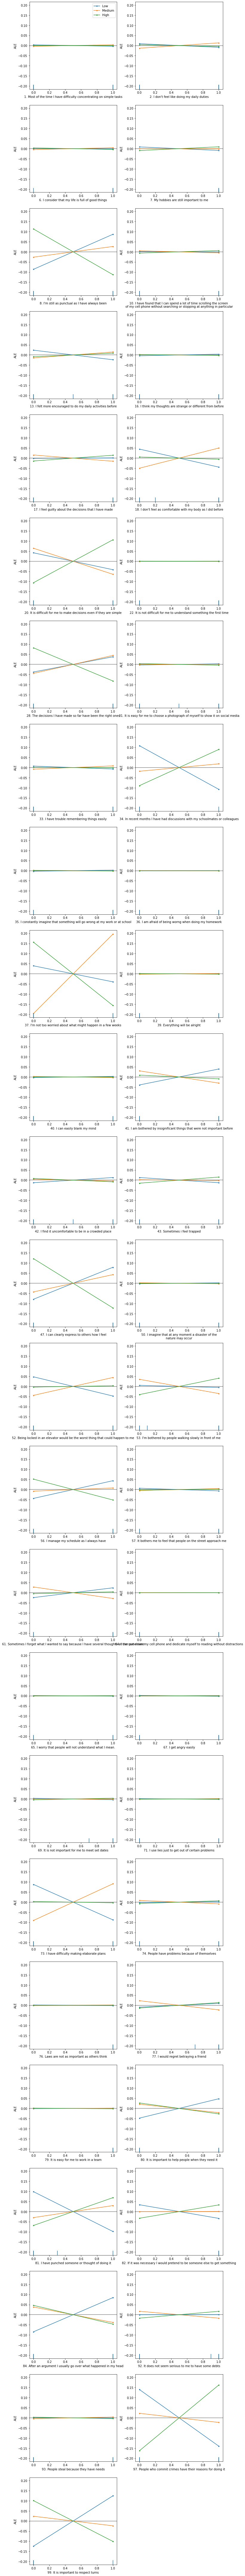

In [76]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 120});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [77]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.006614   -0.000607            NA             NA          NA   
1          2  -0.018055   -0.008497            NA             NA          NA   
2          6  -0.001865   -0.007545            NA             NA          NA   
3          7  -0.017367    0.018536            NA             NA          NA   
4          8   0.173014   -0.225715            NA             NA          NA   
5         10  -0.002792    0.012527            NA             NA          NA   
6         13  -0.047196    0.017650            NA             NA          NA   
7         16   0.007778   -0.004252            NA             NA          NA   
8         17   0.002405    0.028202            NA             NA          NA   
9         18  -0.088971   -0.010765            NA             NA          NA   
10        20  -0.083307    0.212041            NA             NA          NA   
11        22   0.000669   -0.000814            NA             NA          NA   
12        28   0.075218   -0.163893            NA             NA          NA   
13        31   0.005803   -0.007938            NA             NA          NA   
14        33  -0.014158   -0.002098            NA             NA          NA   
15        34  -0.215667    0.178945            NA             NA          NA   
16        35   0.005691   -0.002125            NA             NA          NA   
17        36   0.000568    0.000059            NA             NA          NA   
18        37  -0.079085   -0.312803            NA             NA          NA   
19        39  -0.000589   -0.002836            NA             NA          NA   
20        40   0.005258    0.000021            NA             NA          NA   
21        41   0.078769   -0.018348            NA             NA          NA   
22        42   0.025467   -0.016639            NA             NA          NA   
23        43  -0.025617    0.030172            NA             NA          NA   
24        47   0.157951   -0.243299            NA             NA          NA   
25        50   0.004235    0.000484            NA             NA          NA   
26        52  -0.094860    0.006630            NA             NA          NA   
27        53  -0.010567    0.080953            NA             NA          NA   
28        56   0.087371   -0.103008            NA             NA          NA   
29        57  -0.012926    0.003207            NA             NA          NA   
30        61   0.048206    0.008476            NA             NA          NA   
31        64   0.000347    0.000382            NA             NA          NA   
32        65  -0.002680    0.001158            NA             NA          NA   
33        67  -0.003949    0.002053            NA             NA          NA   
34        69  -0.006850    0.008052            NA             NA          NA   
35        71  -0.003454   -0.000023            NA             NA          NA   
36        73  -0.175165   -0.005994            NA             NA          NA   
37        74   0.003430    0.013733            NA             NA          NA   
38        76  -0.002919    0.000090            NA             NA          NA   
39        77   0.018459    0.026777            NA             NA          NA   
40        79   0.002294   -0.002907            NA             NA          NA   
41        80   0.095816   -0.054058            NA             NA          NA   
42        81  -0.196739    0.137296            NA             NA          NA   
43        82  -0.067398    0.065858            NA             NA          NA   
44        84   0.168791   -0.092529            NA             NA          NA   
45        92   0.000270    0.033853            NA             NA          NA   
46        93  -0.001158   -0.006862            NA             NA          NA   
47        97  -0.279718    0.324933            NA             NA          NA   
48        99   0.248713   -0.201410            NA             NA          NA   

   

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [78]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.006614   -0.000607            NA             NA          NA   
1          2  -0.018055   -0.008497             0             NA          NA   
2          6  -0.001865   -0.007545            NA             NA          NA   
3          7  -0.017367    0.018536             0              1          NA   
4          8   0.173014   -0.225715             1              0          NA   
5         10  -0.002792    0.012527            NA              1          NA   
6         13  -0.047196    0.017650             0              1          NA   
7         16   0.007778   -0.004252            NA             NA          NA   
8         17   0.002405    0.028202            NA              1          NA   
9         18  -0.088971   -0.010765             0              0          NA   
10        20  -0.083307    0.212041             0              1          NA   
11        22   0.000669   -0.000814            NA             NA          NA   
12        28   0.075218   -0.163893             1              0          NA   
13        31   0.005803   -0.007938            NA             NA          NA   
14        33  -0.014158   -0.002098             0             NA          NA   
15        34  -0.215667    0.178945             0              1          NA   
16        35   0.005691   -0.002125            NA             NA          NA   
17        36   0.000568    0.000059            NA             NA          NA   
18        37  -0.079085   -0.312803             0              0          NA   
19        39  -0.000589   -0.002836            NA             NA          NA   
20        40   0.005258    0.000021            NA             NA          NA   
21        41   0.078769   -0.018348             1              0          NA   
22        42   0.025467   -0.016639             1              0          NA   
23        43  -0.025617    0.030172             0              1          NA   
24        47   0.157951   -0.243299             1              0          NA   
25        50   0.004235    0.000484            NA             NA          NA   
26        52  -0.094860    0.006630             0             NA          NA   
27        53  -0.010567    0.080953             0              1          NA   
28        56   0.087371   -0.103008             1              0          NA   
29        57  -0.012926    0.003207             0             NA          NA   
30        61   0.048206    0.008476             1             NA          NA   
31        64   0.000347    0.000382            NA             NA          NA   
32        65  -0.002680    0.001158            NA             NA          NA   
33        67  -0.003949    0.002053            NA             NA          NA   
34        69  -0.006850    0.008052            NA             NA          NA   
35        71  -0.003454   -0.000023            NA             NA          NA   
36        73  -0.175165   -0.005994             0             NA          NA   
37        74   0.003430    0.013733            NA              1          NA   
38        76  -0.002919    0.000090            NA             NA          NA   
39        77   0.018459    0.026777             1              1          NA   
40        79   0.002294   -0.002907            NA             NA          NA   
41        80   0.095816   -0.054058             1              0          NA   
42        81  -0.196739    0.137296             0              1          NA   
43        82  -0.067398    0.065858             0              1          NA   
44        84   0.168791   -0.092529             1              0          NA   
45        92   0.000270    0.033853            NA              1          NA   
46        93  -0.001158   -0.006862            NA             NA          NA   
47        97  -0.279718    0.324933             0              1          NA   
48        99   0.248713   -0.201410             1              0          NA   

   

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [79]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        7             Mis aficiones siguen siendo importante   0
4        8       Sigo siendo tan puntual como siempre he sido   0
5       10  Me he dado cuenta de que puedo pasar mucho tie...   1
6       13  Antes me sentía más animado para hacer mis act...   1
7       16  Creo que mis pensamientos son extraños o disti...   1
8       17    Siento culpa sobre las decisiones que he tomado   1
9       18  No me siento tan cómodo con mi cuerpo como me ...   1
10      20  Me resulta complicado poder tomar decisiones a...   1
11      22      No se me dificulta entender algo a la primera   0
12      28  Las decisiones que he tomado hasta hoy han sid...   0
13      31  Me resulta fácil escoger una fotografía propia...   0
14      33  Tengo dificultades para recordar cosas con fac...   1
15      34  . En los últimos meses he tenido discusiones c...   1
16      35  Constantemente imagino que algo saldrá mal en ...   1
17      36    Tengo miedo de equivocarme al hacer mis deberes   1
18      37  No me preocupa tanto lo que pueda pasar en una...   0
19      39                                   Todo saldrá bien   0
20      40       Puedo poner mi mente en blanco con facilidad   0
21      41  Me molestan cosas insignificantes que antes no...   1
22      42  Me resulta incomodo estar en un espacio donde ...   1
23      43                         A veces me siento atrapado   1
24      47  Puedo expresarle con claridad a los otros cómo...   0
25      50  Imagino que en cualquier momento puede suceder...   1
26      52  Quedarme encerrado en un elevador sería de lo ...   1
27      53  Me molesta la gente que camina lento por la ca...   1
28      56       Manejo mis horarios como siempre lo he hecho   0
29      57  Me incomoda sentir que la gente en la calle se...   1
30      61  A veces olvido lo que quería decir porque teng...   1
31      64  Puedo dejar el celular y dedicarme a leer sin ...   0
32      65  Me preocupa que la gente no entienda lo que qu...   1
33      67                             Me enojo con facilidad   1
34      69  No me resulta importante cumplir con fechas es...   1
35      71  Utilizo las mentiras sólo para salir de alguno...   1
36      73    Tengo dificultades para hacer planes elaborados   1
37      74              La gente tiene problemas por su culpa   1
38      76  Las leyes no son tan importantes como otros creen   1
39      77             Me lamentaría al traicionar a un amigo   0
40      79                  Se me facilita trabajar en equipo   0
41      80  Es importante ayudar a la gente cuando lo nece...   0
42      81      He golpeado a alguien o he pensado en hacerlo   1
43      82  Si fuera necesario me haría pasar por alguien ...   1
44      84  Después de una discusión suelo repasar en mi c...   0
45      92            No me parece grave tener algunas deudas   1
46      93             La gente roba porque tiene necesidades   1
47      97  La gente que comete crímenes tiene sus razones...   1
48      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [80]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.006614   -0.000607            NA             NA          NA   
1          2  -0.018055   -0.008497             0             NA           0   
2          6  -0.001865   -0.007545            NA             NA          NA   
3          7  -0.017367    0.018536             0              1           1   
4          8   0.173014   -0.225715             1              0           0   
5         10  -0.002792    0.012527            NA              1          NA   
6         13  -0.047196    0.017650             0              1           0   
7         16   0.007778   -0.004252            NA             NA          NA   
8         17   0.002405    0.028202            NA              1          NA   
9         18  -0.088971   -0.010765             0              0           0   
10        20  -0.083307    0.212041             0              1           0   
11        22   0.000669   -0.000814            NA             NA          NA   
12        28   0.075218   -0.163893             1              0           0   
13        31   0.005803   -0.007938            NA             NA          NA   
14        33  -0.014158   -0.002098             0             NA           0   
15        34  -0.215667    0.178945             0              1           0   
16        35   0.005691   -0.002125            NA             NA          NA   
17        36   0.000568    0.000059            NA             NA          NA   
18        37  -0.079085   -0.312803             0              0           1   
19        39  -0.000589   -0.002836            NA             NA          NA   
20        40   0.005258    0.000021            NA             NA          NA   
21        41   0.078769   -0.018348             1              0           1   
22        42   0.025467   -0.016639             1              0           1   
23        43  -0.025617    0.030172             0              1           0   
24        47   0.157951   -0.243299             1              0           0   
25        50   0.004235    0.000484            NA             NA          NA   
26        52  -0.094860    0.006630             0             NA           0   
27        53  -0.010567    0.080953             0              1           0   
28        56   0.087371   -0.103008             1              0           0   
29        57  -0.012926    0.003207             0             NA           0   
30        61   0.048206    0.008476             1             NA           1   
31        64   0.000347    0.000382            NA             NA          NA   
32        65  -0.002680    0.001158            NA             NA          NA   
33        67  -0.003949    0.002053            NA             NA          NA   
34        69  -0.006850    0.008052            NA             NA          NA   
35        71  -0.003454   -0.000023            NA             NA          NA   
36        73  -0.175165   -0.005994             0             NA           0   
37        74   0.003430    0.013733            NA              1          NA   
38        76  -0.002919    0.000090            NA             NA          NA   
39        77   0.018459    0.026777             1              1           0   
40        79   0.002294   -0.002907            NA             NA          NA   
41        80   0.095816   -0.054058             1              0           0   
42        81  -0.196739    0.137296             0              1           0   
43        82  -0.067398    0.065858             0              1           0   
44        84   0.168791   -0.092529             1              0           0   
45        92   0.000270    0.033853            NA              1          NA   
46        93  -0.001158   -0.006862            NA             NA          NA   
47        97  -0.279718    0.324933             0              1           0   
48        99   0.248713   -0.201410             1              0           0   

   

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [81]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[7, 18, 41, 42, 77]

## Iteration 4

The fourth iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [82]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1   

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [83]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [84]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [85]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [87]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.28843132176465514,
  0.2776667776667776,
  0.3040008983868633,
  0.2575300255300256,
  0.2575300255300256,
  0.2575300255300256,
  0.2575300255300256,
  0.2575300255300256],
 [0.006020651927912844,
  0.08630510353212997,
  0.09251139902038742,
  0.09711067192502043,
  0.07582590789635271,
  0.07582590789635271,
  0.07582590789635271,
  0.07582590789635271,
  0.07582590789635271])

We proceed to draw the learning curve graph according to the data obtained by the training.

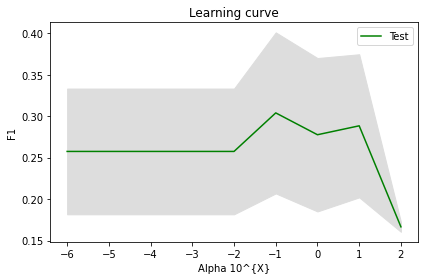

In [88]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [89]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.17806090178006687,
  0.4222391190967042,
  0.43333889593951513,
  0.40979484224066265,
  0.2776667776667776,
  0.16659498207885304,
  0.16659498207885304],
 [0.01757734769209096,
  0.11485289010636886,
  0.13511435367470756,
  0.14103979938781133,
  0.09251139902038742,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

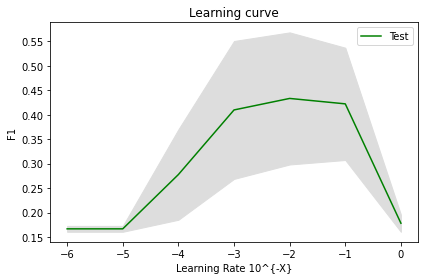

In [90]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [91]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [92]:
joblib.dump(mlp,"model_depression_i4.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

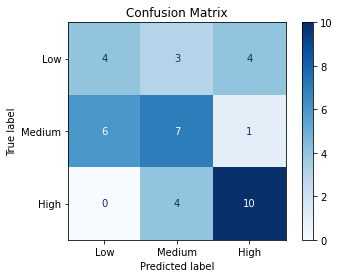

In [93]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [94]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 53.84615384615385 %

              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.50      0.50      0.50        14
           2       0.67      0.71      0.69        14

    accuracy                           0.54        39
   macro avg       0.52      0.53      0.52        39
weighted avg       0.53      0.54      0.53        39



In [95]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,7,9,11,12,14,15,18,19,21,23,24,25,26,27,...        53.846154   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0          0.4  0.363636    0.380952         11          0.5       0.5   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0         0.5         14     0.666667  0.714286    0.689655         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [96]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

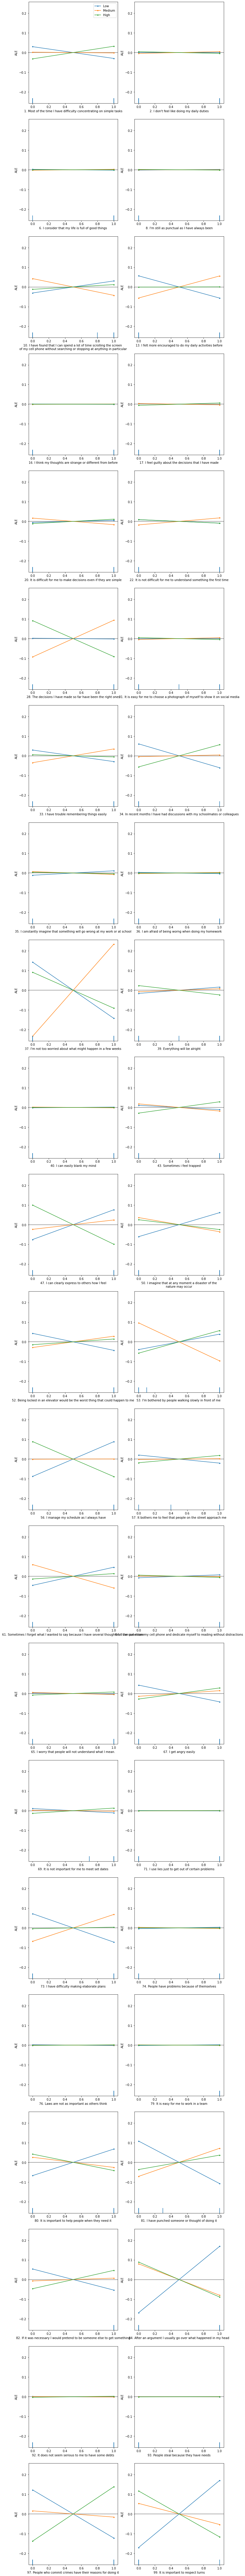

In [97]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [98]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.059830    0.064008            NA             NA          NA   
1          2  -0.000434   -0.008779            NA             NA          NA   
2          6  -0.004093   -0.000412            NA             NA          NA   
3          8   0.003680   -0.003408            NA             NA          NA   
4         10   0.061062    0.023922            NA             NA          NA   
5         13  -0.113167    0.000994            NA             NA          NA   
6         16  -0.001265    0.000027            NA             NA          NA   
7         17  -0.005767    0.012354            NA             NA          NA   
8         20   0.010568    0.022650            NA             NA          NA   
9         22  -0.017375   -0.018091            NA             NA          NA   
10        28  -0.004061   -0.182532            NA             NA          NA   
11        31   0.001788   -0.010339            NA             NA          NA   
12        33  -0.058594   -0.011171            NA             NA          NA   
13        34  -0.121509    0.112861            NA             NA          NA   
14        35   0.022568   -0.008039            NA             NA          NA   
15        36  -0.006471    0.000525            NA             NA          NA   
16        37  -0.285420   -0.182475            NA             NA          NA   
17        39   0.032362   -0.047259            NA             NA          NA   
18        40   0.003534    0.000480            NA             NA          NA   
19        43  -0.021338    0.057640            NA             NA          NA   
20        47   0.151068   -0.198512            NA             NA          NA   
21        50   0.122161   -0.050008            NA             NA          NA   
22        52  -0.086237    0.028765            NA             NA          NA   
23        53   0.078599    0.114902            NA             NA          NA   
24        56   0.176395   -0.177860            NA             NA          NA   
25        57  -0.041006    0.037299            NA             NA          NA   
26        61   0.092091    0.027141            NA             NA          NA   
27        64   0.014939   -0.011734            NA             NA          NA   
28        65  -0.005018    0.015671            NA             NA          NA   
29        67  -0.085142    0.056442            NA             NA          NA   
30        69  -0.021778    0.026632            NA             NA          NA   
31        71  -0.001404    0.000678            NA             NA          NA   
32        73  -0.144125    0.007589            NA             NA          NA   
33        74   0.007009   -0.001137            NA             NA          NA   
34        76  -0.004313    0.002916            NA             NA          NA   
35        79   0.003616   -0.001199            NA             NA          NA   
36        80   0.134843   -0.083349            NA             NA          NA   
37        81  -0.216270    0.073278            NA             NA          NA   
38        82  -0.107243    0.093070            NA             NA          NA   
39        84   0.337728   -0.177842            NA             NA          NA   
40        92  -0.003063    0.005385            NA             NA          NA   
41        93  -0.000901    0.001172            NA             NA          NA   
42        97  -0.244370    0.275903            NA             NA          NA   
43        99   0.341218   -0.233854            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21     

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [99]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.059830    0.064008             0              1          NA   
1          2  -0.000434   -0.008779            NA             NA          NA   
2          6  -0.004093   -0.000412            NA             NA          NA   
3          8   0.003680   -0.003408            NA             NA          NA   
4         10   0.061062    0.023922             1              1          NA   
5         13  -0.113167    0.000994             0             NA          NA   
6         16  -0.001265    0.000027            NA             NA          NA   
7         17  -0.005767    0.012354            NA              1          NA   
8         20   0.010568    0.022650             1              1          NA   
9         22  -0.017375   -0.018091             0              0          NA   
10        28  -0.004061   -0.182532            NA              0          NA   
11        31   0.001788   -0.010339            NA              0          NA   
12        33  -0.058594   -0.011171             0              0          NA   
13        34  -0.121509    0.112861             0              1          NA   
14        35   0.022568   -0.008039             1             NA          NA   
15        36  -0.006471    0.000525            NA             NA          NA   
16        37  -0.285420   -0.182475             0              0          NA   
17        39   0.032362   -0.047259             1              0          NA   
18        40   0.003534    0.000480            NA             NA          NA   
19        43  -0.021338    0.057640             0              1          NA   
20        47   0.151068   -0.198512             1              0          NA   
21        50   0.122161   -0.050008             1              0          NA   
22        52  -0.086237    0.028765             0              1          NA   
23        53   0.078599    0.114902             1              1          NA   
24        56   0.176395   -0.177860             1              0          NA   
25        57  -0.041006    0.037299             0              1          NA   
26        61   0.092091    0.027141             1              1          NA   
27        64   0.014939   -0.011734             1              0          NA   
28        65  -0.005018    0.015671            NA              1          NA   
29        67  -0.085142    0.056442             0              1          NA   
30        69  -0.021778    0.026632             0              1          NA   
31        71  -0.001404    0.000678            NA             NA          NA   
32        73  -0.144125    0.007589             0             NA          NA   
33        74   0.007009   -0.001137            NA             NA          NA   
34        76  -0.004313    0.002916            NA             NA          NA   
35        79   0.003616   -0.001199            NA             NA          NA   
36        80   0.134843   -0.083349             1              0          NA   
37        81  -0.216270    0.073278             0              1          NA   
38        82  -0.107243    0.093070             0              1          NA   
39        84   0.337728   -0.177842             1              0          NA   
40        92  -0.003063    0.005385            NA             NA          NA   
41        93  -0.000901    0.001172            NA             NA          NA   
42        97  -0.244370    0.275903             0              1          NA   
43        99   0.341218   -0.233854             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21     

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [100]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        8       Sigo siendo tan puntual como siempre he sido   0
4       10  Me he dado cuenta de que puedo pasar mucho tie...   1
5       13  Antes me sentía más animado para hacer mis act...   1
6       16  Creo que mis pensamientos son extraños o disti...   1
7       17    Siento culpa sobre las decisiones que he tomado   1
8       20  Me resulta complicado poder tomar decisiones a...   1
9       22      No se me dificulta entender algo a la primera   0
10      28  Las decisiones que he tomado hasta hoy han sid...   0
11      31  Me resulta fácil escoger una fotografía propia...   0
12      33  Tengo dificultades para recordar cosas con fac...   1
13      34  . En los últimos meses he tenido discusiones c...   1
14      35  Constantemente imagino que algo saldrá mal en ...   1
15      36    Tengo miedo de equivocarme al hacer mis deberes   1
16      37  No me preocupa tanto lo que pueda pasar en una...   0
17      39                                   Todo saldrá bien   0
18      40       Puedo poner mi mente en blanco con facilidad   0
19      43                         A veces me siento atrapado   1
20      47  Puedo expresarle con claridad a los otros cómo...   0
21      50  Imagino que en cualquier momento puede suceder...   1
22      52  Quedarme encerrado en un elevador sería de lo ...   1
23      53  Me molesta la gente que camina lento por la ca...   1
24      56       Manejo mis horarios como siempre lo he hecho   0
25      57  Me incomoda sentir que la gente en la calle se...   1
26      61  A veces olvido lo que quería decir porque teng...   1
27      64  Puedo dejar el celular y dedicarme a leer sin ...   0
28      65  Me preocupa que la gente no entienda lo que qu...   1
29      67                             Me enojo con facilidad   1
30      69  No me resulta importante cumplir con fechas es...   1
31      71  Utilizo las mentiras sólo para salir de alguno...   1
32      73    Tengo dificultades para hacer planes elaborados   1
33      74              La gente tiene problemas por su culpa   1
34      76  Las leyes no son tan importantes como otros creen   1
35      79                  Se me facilita trabajar en equipo   0
36      80  Es importante ayudar a la gente cuando lo nece...   0
37      81      He golpeado a alguien o he pensado en hacerlo   1
38      82  Si fuera necesario me haría pasar por alguien ...   1
39      84  Después de una discusión suelo repasar en mi c...   0
40      92            No me parece grave tener algunas deudas   1
41      93             La gente roba porque tiene necesidades   1
42      97  La gente que comete crímenes tiene sus razones...   1
43      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [101]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.059830    0.064008             0              1           0   
1          2  -0.000434   -0.008779            NA             NA          NA   
2          6  -0.004093   -0.000412            NA             NA          NA   
3          8   0.003680   -0.003408            NA             NA          NA   
4         10   0.061062    0.023922             1              1           1   
5         13  -0.113167    0.000994             0             NA           0   
6         16  -0.001265    0.000027            NA             NA          NA   
7         17  -0.005767    0.012354            NA              1          NA   
8         20   0.010568    0.022650             1              1           1   
9         22  -0.017375   -0.018091             0              0           1   
10        28  -0.004061   -0.182532            NA              0          NA   
11        31   0.001788   -0.010339            NA              0          NA   
12        33  -0.058594   -0.011171             0              0           0   
13        34  -0.121509    0.112861             0              1           0   
14        35   0.022568   -0.008039             1             NA           1   
15        36  -0.006471    0.000525            NA             NA          NA   
16        37  -0.285420   -0.182475             0              0           1   
17        39   0.032362   -0.047259             1              0           0   
18        40   0.003534    0.000480            NA             NA          NA   
19        43  -0.021338    0.057640             0              1           0   
20        47   0.151068   -0.198512             1              0           0   
21        50   0.122161   -0.050008             1              0           1   
22        52  -0.086237    0.028765             0              1           0   
23        53   0.078599    0.114902             1              1           1   
24        56   0.176395   -0.177860             1              0           0   
25        57  -0.041006    0.037299             0              1           0   
26        61   0.092091    0.027141             1              1           1   
27        64   0.014939   -0.011734             1              0           0   
28        65  -0.005018    0.015671            NA              1          NA   
29        67  -0.085142    0.056442             0              1           0   
30        69  -0.021778    0.026632             0              1           0   
31        71  -0.001404    0.000678            NA             NA          NA   
32        73  -0.144125    0.007589             0             NA           0   
33        74   0.007009   -0.001137            NA             NA          NA   
34        76  -0.004313    0.002916            NA             NA          NA   
35        79   0.003616   -0.001199            NA             NA          NA   
36        80   0.134843   -0.083349             1              0           0   
37        81  -0.216270    0.073278             0              1           0   
38        82  -0.107243    0.093070             0              1           0   
39        84   0.337728   -0.177842             1              0           0   
40        92  -0.003063    0.005385            NA             NA          NA   
41        93  -0.000901    0.001172            NA             NA          NA   
42        97  -0.244370    0.275903             0              1           0   
43        99   0.341218   -0.233854             1              0           0   

   Anomaly High  
0             0  
1            NA  
2            NA  
3            NA  
4             0  
5            NA  
6            NA  
7             0  
8             0  
9             0  
10            0  
11            0  
12            1  
13            0  
14           NA  
15           NA  
16            0  
17            0  
18           NA  
19            0  
20            0  
21     

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [102]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[33, 50]

## Iteration 5

The fifth iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [103]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1   

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [104]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [105]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [106]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [108]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.1632974910394265,
  0.17910044977511244,
  0.2134900489183255,
  0.21796835709129558,
  0.22441781406706837,
  0.22441781406706837,
  0.22441781406706837,
  0.22441781406706837,
  0.22441781406706837],
 [0.006619092595549127,
  0.03738199764605503,
  0.03759666129433013,
  0.045505150536351104,
  0.044780893408842184,
  0.044780893408842184,
  0.044780893408842184,
  0.044780893408842184,
  0.044780893408842184])

We proceed to draw the learning curve graph according to the data obtained by the training.

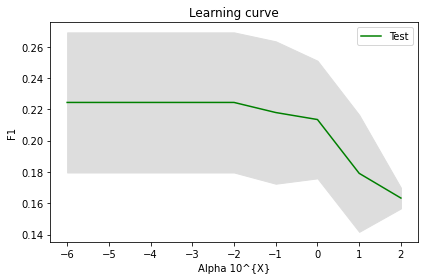

In [109]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [110]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.1927316172477463,
  0.3981073284014461,
  0.4116582866737666,
  0.4064239028944911,
  0.2134900489183255,
  0.16947033054559935,
  0.16947033054559935],
 [0.06900121176816054,
  0.06226522543522221,
  0.07041327278291896,
  0.0451835151409837,
  0.03759666129433013,
  0.040956253005396466,
  0.040956253005396466])

We proceed to draw the learning curve graph according to the data obtained by the training.

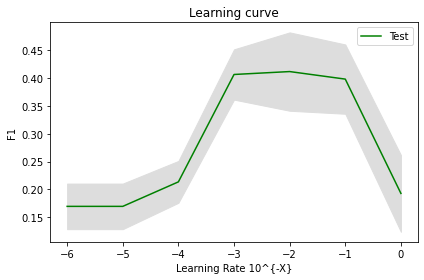

In [111]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [112]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [113]:
joblib.dump(mlp,"model_depression_i5.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

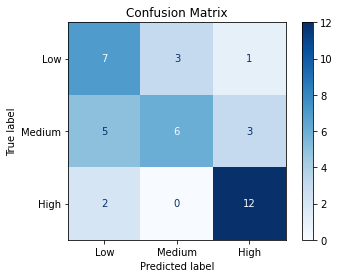

In [114]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [115]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 64.1025641025641 %

              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.67      0.43      0.52        14
           2       0.75      0.86      0.80        14

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.63        39
weighted avg       0.65      0.64      0.63        39



In [116]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,7,9,11,12,14,15,18,19,21,23,24,25,26,27,...        64.102564   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0          0.5  0.636364        0.56         11     0.666667  0.428571   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.521739         14         0.75  0.857143         0.8         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [117]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

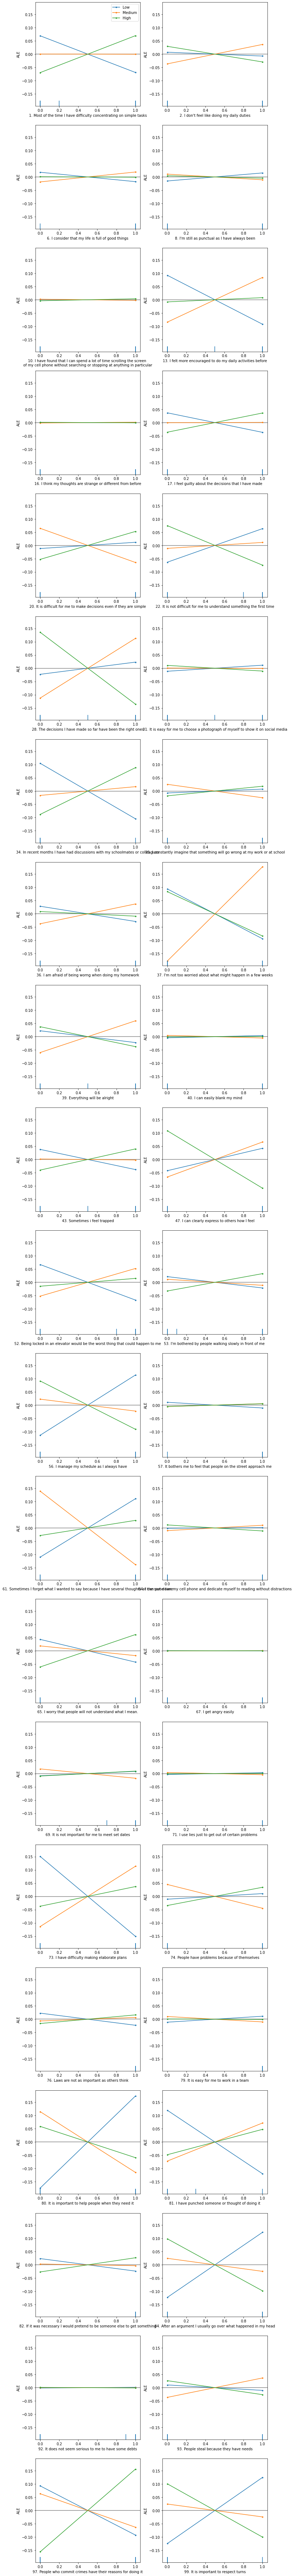

In [118]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [119]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.138471    0.139419            NA             NA          NA   
1          2  -0.014418   -0.058997            NA             NA          NA   
2          6  -0.035443   -0.001914            NA             NA          NA   
3          8   0.030353   -0.008966            NA             NA          NA   
4         10  -0.003401    0.007547            NA             NA          NA   
5         13  -0.184835    0.016001            NA             NA          NA   
6         16  -0.001500   -0.001485            NA             NA          NA   
7         17  -0.073803    0.072450            NA             NA          NA   
8         20   0.023498    0.105458            NA             NA          NA   
9         22   0.126786   -0.149254            NA             NA          NA   
10        28   0.046047   -0.271337            NA             NA          NA   
11        31   0.022856   -0.021373            NA             NA          NA   
12        34  -0.209418    0.176432            NA             NA          NA   
13        35   0.014491    0.036310            NA             NA          NA   
14        36  -0.057434   -0.017369            NA             NA          NA   
15        37  -0.188355   -0.167515            NA             NA          NA   
16        39  -0.044542   -0.075195            NA             NA          NA   
17        40   0.008666    0.001338            NA             NA          NA   
18        43  -0.076150    0.079928            NA             NA          NA   
19        47   0.084578   -0.216880            NA             NA          NA   
20        52  -0.134024    0.029649            NA             NA          NA   
21        53  -0.042884    0.065600            NA             NA          NA   
22        56   0.227314   -0.182310            NA             NA          NA   
23        57  -0.021442    0.010315            NA             NA          NA   
24        61   0.220355    0.057112            NA             NA          NA   
25        64   0.002489   -0.022714            NA             NA          NA   
26        65  -0.085756    0.122335            NA             NA          NA   
27        67  -0.000983    0.000060            NA             NA          NA   
28        69   0.016604    0.018549            NA             NA          NA   
29        71   0.006508    0.001896            NA             NA          NA   
30        73  -0.301636    0.074206            NA             NA          NA   
31        74   0.021063    0.068859            NA             NA          NA   
32        76  -0.045770    0.032442            NA             NA          NA   
33        79   0.022489   -0.002098            NA             NA          NA   
34        80   0.347419   -0.118070            NA             NA          NA   
35        81  -0.239696    0.095886            NA             NA          NA   
36        82  -0.047219    0.053466            NA             NA          NA   
37        84   0.245807   -0.196578            NA             NA          NA   
38        92   0.002754   -0.001976            NA             NA          NA   
39        93  -0.020514   -0.052821            NA             NA          NA   
40        97  -0.185595    0.312015            NA             NA          NA   
41        99   0.249844   -0.201260            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30   

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [120]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.138471    0.139419             0              1          NA   
1          2  -0.014418   -0.058997             0              0          NA   
2          6  -0.035443   -0.001914             0             NA          NA   
3          8   0.030353   -0.008966             1             NA          NA   
4         10  -0.003401    0.007547            NA             NA          NA   
5         13  -0.184835    0.016001             0              1          NA   
6         16  -0.001500   -0.001485            NA             NA          NA   
7         17  -0.073803    0.072450             0              1          NA   
8         20   0.023498    0.105458             1              1          NA   
9         22   0.126786   -0.149254             1              0          NA   
10        28   0.046047   -0.271337             1              0          NA   
11        31   0.022856   -0.021373             1              0          NA   
12        34  -0.209418    0.176432             0              1          NA   
13        35   0.014491    0.036310             1              1          NA   
14        36  -0.057434   -0.017369             0              0          NA   
15        37  -0.188355   -0.167515             0              0          NA   
16        39  -0.044542   -0.075195             0              0          NA   
17        40   0.008666    0.001338            NA             NA          NA   
18        43  -0.076150    0.079928             0              1          NA   
19        47   0.084578   -0.216880             1              0          NA   
20        52  -0.134024    0.029649             0              1          NA   
21        53  -0.042884    0.065600             0              1          NA   
22        56   0.227314   -0.182310             1              0          NA   
23        57  -0.021442    0.010315             0              1          NA   
24        61   0.220355    0.057112             1              1          NA   
25        64   0.002489   -0.022714            NA              0          NA   
26        65  -0.085756    0.122335             0              1          NA   
27        67  -0.000983    0.000060            NA             NA          NA   
28        69   0.016604    0.018549             1              1          NA   
29        71   0.006508    0.001896            NA             NA          NA   
30        73  -0.301636    0.074206             0              1          NA   
31        74   0.021063    0.068859             1              1          NA   
32        76  -0.045770    0.032442             0              1          NA   
33        79   0.022489   -0.002098             1             NA          NA   
34        80   0.347419   -0.118070             1              0          NA   
35        81  -0.239696    0.095886             0              1          NA   
36        82  -0.047219    0.053466             0              1          NA   
37        84   0.245807   -0.196578             1              0          NA   
38        92   0.002754   -0.001976            NA             NA          NA   
39        93  -0.020514   -0.052821             0              0          NA   
40        97  -0.185595    0.312015             0              1          NA   
41        99   0.249844   -0.201260             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30   

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [121]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        8       Sigo siendo tan puntual como siempre he sido   0
4       10  Me he dado cuenta de que puedo pasar mucho tie...   1
5       13  Antes me sentía más animado para hacer mis act...   1
6       16  Creo que mis pensamientos son extraños o disti...   1
7       17    Siento culpa sobre las decisiones que he tomado   1
8       20  Me resulta complicado poder tomar decisiones a...   1
9       22      No se me dificulta entender algo a la primera   0
10      28  Las decisiones que he tomado hasta hoy han sid...   0
11      31  Me resulta fácil escoger una fotografía propia...   0
12      34  . En los últimos meses he tenido discusiones c...   1
13      35  Constantemente imagino que algo saldrá mal en ...   1
14      36    Tengo miedo de equivocarme al hacer mis deberes   1
15      37  No me preocupa tanto lo que pueda pasar en una...   0
16      39                                   Todo saldrá bien   0
17      40       Puedo poner mi mente en blanco con facilidad   0
18      43                         A veces me siento atrapado   1
19      47  Puedo expresarle con claridad a los otros cómo...   0
20      52  Quedarme encerrado en un elevador sería de lo ...   1
21      53  Me molesta la gente que camina lento por la ca...   1
22      56       Manejo mis horarios como siempre lo he hecho   0
23      57  Me incomoda sentir que la gente en la calle se...   1
24      61  A veces olvido lo que quería decir porque teng...   1
25      64  Puedo dejar el celular y dedicarme a leer sin ...   0
26      65  Me preocupa que la gente no entienda lo que qu...   1
27      67                             Me enojo con facilidad   1
28      69  No me resulta importante cumplir con fechas es...   1
29      71  Utilizo las mentiras sólo para salir de alguno...   1
30      73    Tengo dificultades para hacer planes elaborados   1
31      74              La gente tiene problemas por su culpa   1
32      76  Las leyes no son tan importantes como otros creen   1
33      79                  Se me facilita trabajar en equipo   0
34      80  Es importante ayudar a la gente cuando lo nece...   0
35      81      He golpeado a alguien o he pensado en hacerlo   1
36      82  Si fuera necesario me haría pasar por alguien ...   1
37      84  Después de una discusión suelo repasar en mi c...   0
38      92            No me parece grave tener algunas deudas   1
39      93             La gente roba porque tiene necesidades   1
40      97  La gente que comete crímenes tiene sus razones...   1
41      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [122]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.138471    0.139419             0              1           0   
1          2  -0.014418   -0.058997             0              0           0   
2          6  -0.035443   -0.001914             0             NA           1   
3          8   0.030353   -0.008966             1             NA           0   
4         10  -0.003401    0.007547            NA             NA          NA   
5         13  -0.184835    0.016001             0              1           0   
6         16  -0.001500   -0.001485            NA             NA          NA   
7         17  -0.073803    0.072450             0              1           0   
8         20   0.023498    0.105458             1              1           1   
9         22   0.126786   -0.149254             1              0           0   
10        28   0.046047   -0.271337             1              0           0   
11        31   0.022856   -0.021373             1              0           0   
12        34  -0.209418    0.176432             0              1           0   
13        35   0.014491    0.036310             1              1           1   
14        36  -0.057434   -0.017369             0              0           0   
15        37  -0.188355   -0.167515             0              0           1   
16        39  -0.044542   -0.075195             0              0           1   
17        40   0.008666    0.001338            NA             NA          NA   
18        43  -0.076150    0.079928             0              1           0   
19        47   0.084578   -0.216880             1              0           0   
20        52  -0.134024    0.029649             0              1           0   
21        53  -0.042884    0.065600             0              1           0   
22        56   0.227314   -0.182310             1              0           0   
23        57  -0.021442    0.010315             0              1           0   
24        61   0.220355    0.057112             1              1           1   
25        64   0.002489   -0.022714            NA              0          NA   
26        65  -0.085756    0.122335             0              1           0   
27        67  -0.000983    0.000060            NA             NA          NA   
28        69   0.016604    0.018549             1              1           1   
29        71   0.006508    0.001896            NA             NA          NA   
30        73  -0.301636    0.074206             0              1           0   
31        74   0.021063    0.068859             1              1           1   
32        76  -0.045770    0.032442             0              1           0   
33        79   0.022489   -0.002098             1             NA           0   
34        80   0.347419   -0.118070             1              0           0   
35        81  -0.239696    0.095886             0              1           0   
36        82  -0.047219    0.053466             0              1           0   
37        84   0.245807   -0.196578             1              0           0   
38        92   0.002754   -0.001976            NA             NA          NA   
39        93  -0.020514   -0.052821             0              0           0   
40        97  -0.185595    0.312015             0              1           0   
41        99   0.249844   -0.201260             1              0           0   

   Anomaly High  
0             0  
1             1  
2            NA  
3            NA  
4            NA  
5             0  
6            NA  
7             0  
8             0  
9             0  
10            0  
11            0  
12            0  
13            0  
14            1  
15            0  
16            0  
17           NA  
18            0  
19            0  
20            0  
21            0  
22            0  
23            0  
24            0  
25            0  
26            0  
27           NA  
28            0  
29           NA  
30   

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [123]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[2, 36, 93]

## Iteration 6

The sixth iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [124]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1                                                                                                 
100                                                  0                                                                                                 
101                                                  1                                                                                                 
102                                                  1                                                                                                 
103                                                  1        

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [125]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [126]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [127]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [129]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.1632974910394265,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.006619092595549127,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

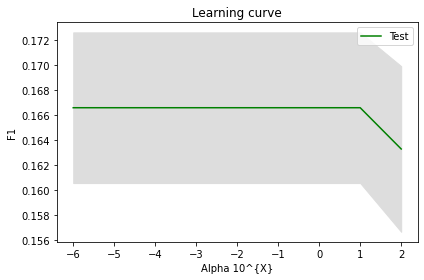

In [130]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [131]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.16989247311827954,
  0.40041358080057776,
  0.42131415425533064,
  0.4048821113526996,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.002633859938476533,
  0.022573278819447408,
  0.06436412560720102,
  0.03753187387238331,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

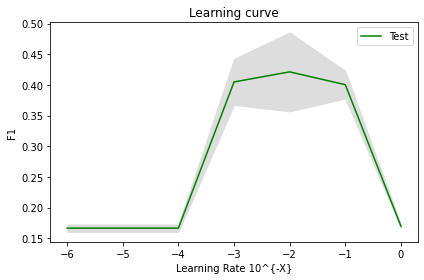

In [132]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [133]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [134]:
joblib.dump(mlp,"model_depression_i6.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

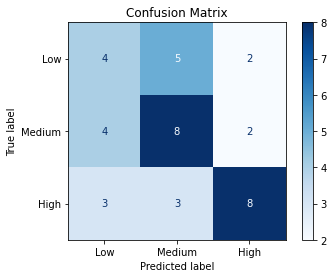

In [135]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [136]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 51.28205128205128 %

              precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.50      0.57      0.53        14
           2       0.67      0.57      0.62        14

    accuracy                           0.51        39
   macro avg       0.51      0.50      0.50        39
weighted avg       0.52      0.51      0.51        39



In [137]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  2,3,4,5,7,9,11,12,14,15,18,19,21,23,24,25,26,2...        51.282051   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.363636  0.363636    0.363636         11          0.5  0.571429   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.533333         14     0.666667  0.571429    0.615385         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [138]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

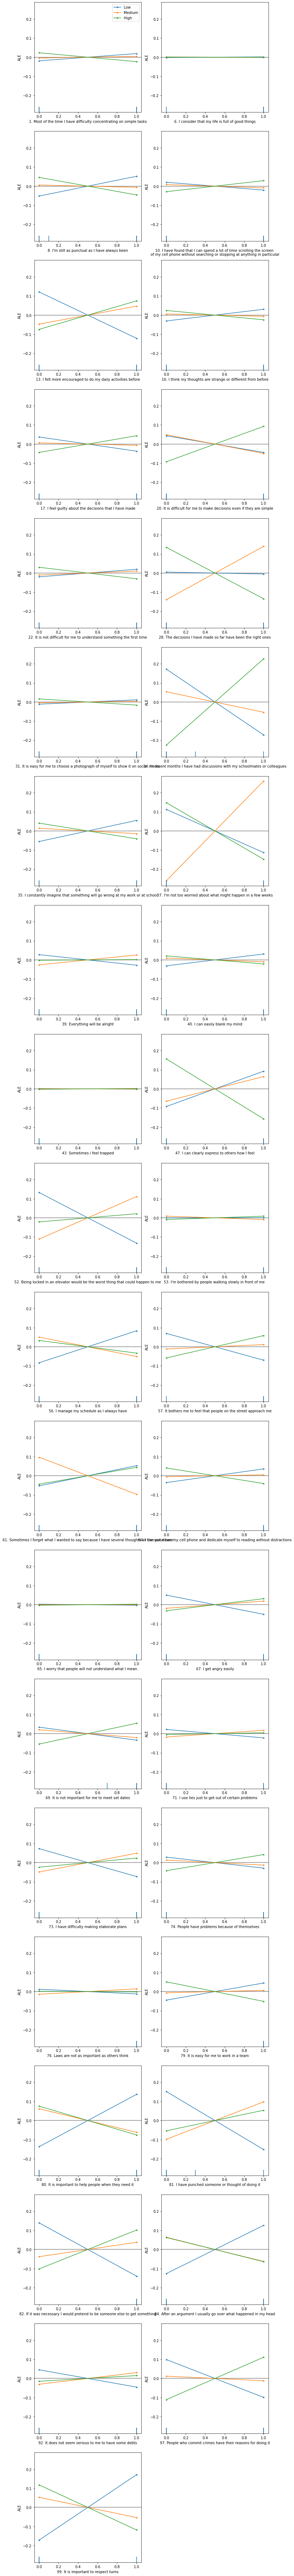

In [139]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [140]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1   0.037745   -0.046383            NA             NA          NA   
1          6   0.003588   -0.000966            NA             NA          NA   
2          8   0.103508   -0.091507            NA             NA          NA   
3         10  -0.040895    0.057785            NA             NA          NA   
4         13  -0.242524    0.148865            NA             NA          NA   
5         16   0.061113   -0.048968            NA             NA          NA   
6         17  -0.074225    0.086977            NA             NA          NA   
7         20  -0.087052    0.185142            NA             NA          NA   
8         22   0.039517   -0.060106            NA             NA          NA   
9         28  -0.009943   -0.269066            NA             NA          NA   
10        31   0.023127   -0.032159            NA             NA          NA   
11        34  -0.344119    0.451545            NA             NA          NA   
12        35   0.110226   -0.081951            NA             NA          NA   
13        37  -0.226109   -0.296268            NA             NA          NA   
14        39  -0.055197    0.003804            NA             NA          NA   
15        40   0.061901   -0.042292            NA             NA          NA   
16        43  -0.003528    0.004527            NA             NA          NA   
17        47   0.185098   -0.313902            NA             NA          NA   
18        52  -0.264757    0.042665            NA             NA          NA   
19        53   0.000508    0.017378            NA             NA          NA   
20        56   0.167221   -0.066015            NA             NA          NA   
21        57  -0.140050    0.117020            NA             NA          NA   
22        61   0.105674    0.087818            NA             NA          NA   
23        64   0.071723   -0.081537            NA             NA          NA   
24        65  -0.005747    0.005855            NA             NA          NA   
25        67  -0.100421    0.063046            NA             NA          NA   
26        69  -0.067829    0.108466            NA             NA          NA   
27        71  -0.044020    0.009237            NA             NA          NA   
28        73  -0.146033    0.047863            NA             NA          NA   
29        74  -0.057533    0.084209            NA             NA          NA   
30        76  -0.024292   -0.003752            NA             NA          NA   
31        79   0.089584   -0.102379            NA             NA          NA   
32        80   0.273549   -0.150538            NA             NA          NA   
33        81  -0.303554    0.107592            NA             NA          NA   
34        82  -0.278285    0.203135            NA             NA          NA   
35        84   0.252204   -0.127769            NA             NA          NA   
36        92  -0.090408    0.029823            NA             NA          NA   
37        97  -0.198281    0.221906            NA             NA          NA   
38        99   0.341788   -0.235594            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA  
32           NA  
33           NA  
34           NA  
35           NA  
36           NA  
37           NA  
38           NA

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [141]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1   0.037745   -0.046383             1              0          NA   
1          6   0.003588   -0.000966            NA             NA          NA   
2          8   0.103508   -0.091507             1              0          NA   
3         10  -0.040895    0.057785             0              1          NA   
4         13  -0.242524    0.148865             0              1          NA   
5         16   0.061113   -0.048968             1              0          NA   
6         17  -0.074225    0.086977             0              1          NA   
7         20  -0.087052    0.185142             0              1          NA   
8         22   0.039517   -0.060106             1              0          NA   
9         28  -0.009943   -0.269066            NA              0          NA   
10        31   0.023127   -0.032159             1              0          NA   
11        34  -0.344119    0.451545             0              1          NA   
12        35   0.110226   -0.081951             1              0          NA   
13        37  -0.226109   -0.296268             0              0          NA   
14        39  -0.055197    0.003804             0             NA          NA   
15        40   0.061901   -0.042292             1              0          NA   
16        43  -0.003528    0.004527            NA             NA          NA   
17        47   0.185098   -0.313902             1              0          NA   
18        52  -0.264757    0.042665             0              1          NA   
19        53   0.000508    0.017378            NA              1          NA   
20        56   0.167221   -0.066015             1              0          NA   
21        57  -0.140050    0.117020             0              1          NA   
22        61   0.105674    0.087818             1              1          NA   
23        64   0.071723   -0.081537             1              0          NA   
24        65  -0.005747    0.005855            NA             NA          NA   
25        67  -0.100421    0.063046             0              1          NA   
26        69  -0.067829    0.108466             0              1          NA   
27        71  -0.044020    0.009237             0             NA          NA   
28        73  -0.146033    0.047863             0              1          NA   
29        74  -0.057533    0.084209             0              1          NA   
30        76  -0.024292   -0.003752             0             NA          NA   
31        79   0.089584   -0.102379             1              0          NA   
32        80   0.273549   -0.150538             1              0          NA   
33        81  -0.303554    0.107592             0              1          NA   
34        82  -0.278285    0.203135             0              1          NA   
35        84   0.252204   -0.127769             1              0          NA   
36        92  -0.090408    0.029823             0              1          NA   
37        97  -0.198281    0.221906             0              1          NA   
38        99   0.341788   -0.235594             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA  
32           NA  
33           NA  
34           NA  
35           NA  
36           NA  
37           NA  
38           NA

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [142]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        6   Considero que mi vida está llena de cosas buenas   0
2        8       Sigo siendo tan puntual como siempre he sido   0
3       10  Me he dado cuenta de que puedo pasar mucho tie...   1
4       13  Antes me sentía más animado para hacer mis act...   1
5       16  Creo que mis pensamientos son extraños o disti...   1
6       17    Siento culpa sobre las decisiones que he tomado   1
7       20  Me resulta complicado poder tomar decisiones a...   1
8       22      No se me dificulta entender algo a la primera   0
9       28  Las decisiones que he tomado hasta hoy han sid...   0
10      31  Me resulta fácil escoger una fotografía propia...   0
11      34  . En los últimos meses he tenido discusiones c...   1
12      35  Constantemente imagino que algo saldrá mal en ...   1
13      37  No me preocupa tanto lo que pueda pasar en una...   0
14      39                                   Todo saldrá bien   0
15      40       Puedo poner mi mente en blanco con facilidad   0
16      43                         A veces me siento atrapado   1
17      47  Puedo expresarle con claridad a los otros cómo...   0
18      52  Quedarme encerrado en un elevador sería de lo ...   1
19      53  Me molesta la gente que camina lento por la ca...   1
20      56       Manejo mis horarios como siempre lo he hecho   0
21      57  Me incomoda sentir que la gente en la calle se...   1
22      61  A veces olvido lo que quería decir porque teng...   1
23      64  Puedo dejar el celular y dedicarme a leer sin ...   0
24      65  Me preocupa que la gente no entienda lo que qu...   1
25      67                             Me enojo con facilidad   1
26      69  No me resulta importante cumplir con fechas es...   1
27      71  Utilizo las mentiras sólo para salir de alguno...   1
28      73    Tengo dificultades para hacer planes elaborados   1
29      74              La gente tiene problemas por su culpa   1
30      76  Las leyes no son tan importantes como otros creen   1
31      79                  Se me facilita trabajar en equipo   0
32      80  Es importante ayudar a la gente cuando lo nece...   0
33      81      He golpeado a alguien o he pensado en hacerlo   1
34      82  Si fuera necesario me haría pasar por alguien ...   1
35      84  Después de una discusión suelo repasar en mi c...   0
36      92            No me parece grave tener algunas deudas   1
37      97  La gente que comete crímenes tiene sus razones...   1
38      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [143]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1   0.037745   -0.046383             1              0           1   
1          6   0.003588   -0.000966            NA             NA          NA   
2          8   0.103508   -0.091507             1              0           0   
3         10  -0.040895    0.057785             0              1           0   
4         13  -0.242524    0.148865             0              1           0   
5         16   0.061113   -0.048968             1              0           1   
6         17  -0.074225    0.086977             0              1           0   
7         20  -0.087052    0.185142             0              1           0   
8         22   0.039517   -0.060106             1              0           0   
9         28  -0.009943   -0.269066            NA              0          NA   
10        31   0.023127   -0.032159             1              0           0   
11        34  -0.344119    0.451545             0              1           0   
12        35   0.110226   -0.081951             1              0           1   
13        37  -0.226109   -0.296268             0              0           1   
14        39  -0.055197    0.003804             0             NA           1   
15        40   0.061901   -0.042292             1              0           0   
16        43  -0.003528    0.004527            NA             NA          NA   
17        47   0.185098   -0.313902             1              0           0   
18        52  -0.264757    0.042665             0              1           0   
19        53   0.000508    0.017378            NA              1          NA   
20        56   0.167221   -0.066015             1              0           0   
21        57  -0.140050    0.117020             0              1           0   
22        61   0.105674    0.087818             1              1           1   
23        64   0.071723   -0.081537             1              0           0   
24        65  -0.005747    0.005855            NA             NA          NA   
25        67  -0.100421    0.063046             0              1           0   
26        69  -0.067829    0.108466             0              1           0   
27        71  -0.044020    0.009237             0             NA           0   
28        73  -0.146033    0.047863             0              1           0   
29        74  -0.057533    0.084209             0              1           0   
30        76  -0.024292   -0.003752             0             NA           0   
31        79   0.089584   -0.102379             1              0           0   
32        80   0.273549   -0.150538             1              0           0   
33        81  -0.303554    0.107592             0              1           0   
34        82  -0.278285    0.203135             0              1           0   
35        84   0.252204   -0.127769             1              0           0   
36        92  -0.090408    0.029823             0              1           0   
37        97  -0.198281    0.221906             0              1           0   
38        99   0.341788   -0.235594             1              0           0   

   Anomaly High  
0             1  
1            NA  
2             0  
3             0  
4             0  
5             1  
6             0  
7             0  
8             0  
9             0  
10            0  
11            0  
12            1  
13            0  
14           NA  
15            0  
16           NA  
17            0  
18            0  
19            0  
20            0  
21            0  
22            0  
23            0  
24           NA  
25            0  
26            0  
27           NA  
28            0  
29            0  
30           NA  
31            0  
32            0  
33            0  
34            0  
35            0  
36            0  
37            0  
38            0

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [144]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[1, 16, 35]

## Iteration 7

The seventh iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [145]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1                                                                                                 
100                                                  0                                                                                                 
101                                                  1                                                                                                 
102                                                  1                                                                                                 
103                                                  1                                                                                                 

     13. I felt more encouraged to do my daily activities before  \
0                                                    0             
1                                                    1             
2                                                    0             
3                                                    1             
4                                                    0             
..                                                 ...             
99                                                   1             
100                                                  1             
101                                                  1             
102                                                  0             
103                                                  0             

     

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [146]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [147]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [148]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [150]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.1497243851192683,
  0.16188993061073148,
  0.16396631177498805,
  0.16396631177498805,
  0.16396631177498805,
  0.16396631177498805,
  0.16396631177498805],
 [0.006020651927912844,
  0.006020651927912844,
  0.01095327408190148,
  0.03319646273110656,
  0.03274304788507844,
  0.03274304788507844,
  0.03274304788507844,
  0.03274304788507844,
  0.03274304788507844])

We proceed to draw the learning curve graph according to the data obtained by the training.

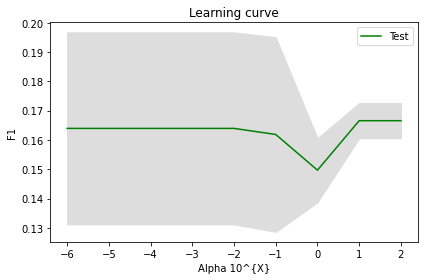

In [151]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [152]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.18580246913580245,
  0.4277402845978697,
  0.43522705708464215,
  0.4446880965611616,
  0.1497243851192683,
  0.16659498207885304,
  0.16659498207885304],
 [0.03837898119056879,
  0.03747002917070688,
  0.04528474596206633,
  0.028780125449296177,
  0.01095327408190148,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

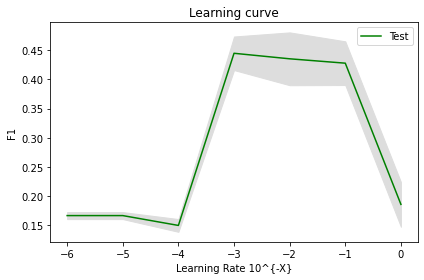

In [153]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [154]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [155]:
joblib.dump(mlp,"model_depression_i7.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

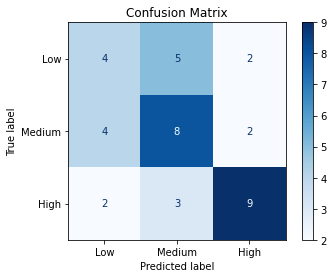

In [156]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [157]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 53.84615384615385 %

              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.50      0.57      0.53        14
           2       0.69      0.64      0.67        14

    accuracy                           0.54        39
   macro avg       0.53      0.53      0.53        39
weighted avg       0.54      0.54      0.54        39



In [158]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  1,2,3,4,5,7,9,11,12,14,15,16,18,19,21,23,24,25...        53.846154   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0          0.4  0.363636    0.380952         11          0.5  0.571429   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.533333         14     0.692308  0.642857    0.666667         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [159]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

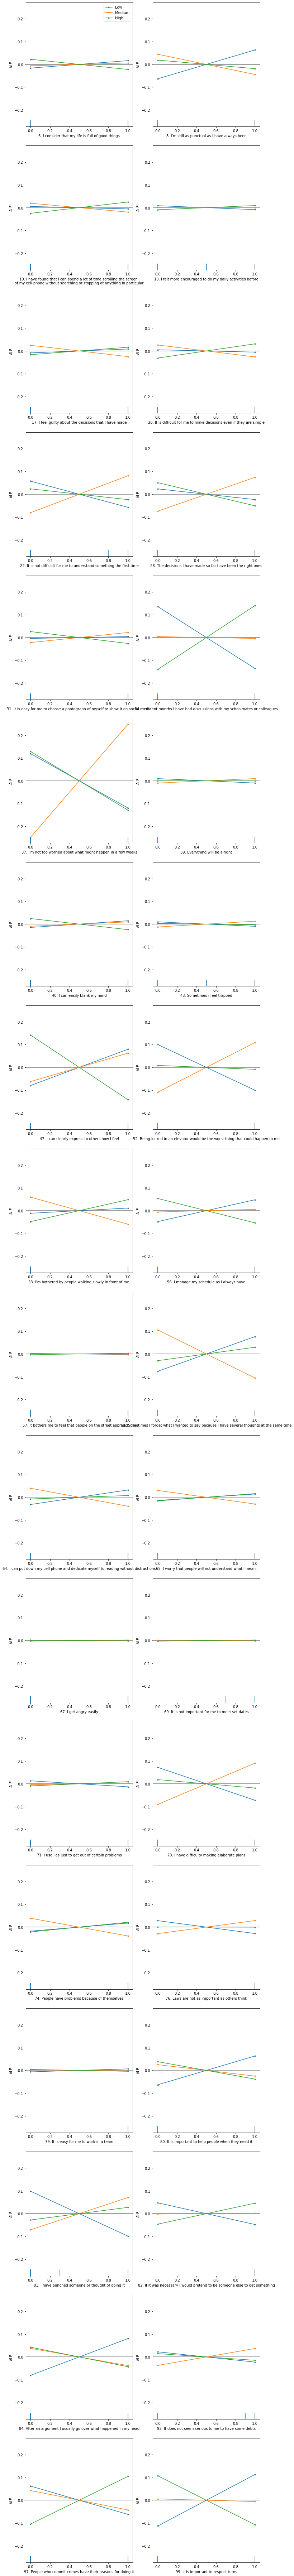

In [160]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [161]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6   0.032648   -0.044664            NA             NA          NA   
1          8   0.126573   -0.037672            NA             NA          NA   
2         10  -0.010733    0.049588            NA             NA          NA   
3         13  -0.017315    0.018499            NA             NA          NA   
4         17   0.016859    0.032759            NA             NA          NA   
5         20  -0.010311    0.062439            NA             NA          NA   
6         22  -0.114843   -0.047169            NA             NA          NA   
7         28  -0.046881   -0.101661            NA             NA          NA   
8         31   0.008161   -0.052244            NA             NA          NA   
9         34  -0.272183    0.280418            NA             NA          NA   
10        37  -0.238222   -0.257174            NA             NA          NA   
11        39  -0.019448   -0.000321            NA             NA          NA   
12        40   0.029474   -0.048670            NA             NA          NA   
13        43  -0.019564   -0.005797            NA             NA          NA   
14        47   0.158905   -0.283337            NA             NA          NA   
15        52  -0.200890   -0.017093            NA             NA          NA   
16        53   0.022762    0.096146            NA             NA          NA   
17        56   0.095921   -0.107135            NA             NA          NA   
18        57  -0.004493    0.006707            NA             NA          NA   
19        61   0.152317    0.059031            NA             NA          NA   
20        64   0.063777    0.015105            NA             NA          NA   
21        65   0.028073    0.031777            NA             NA          NA   
22        67  -0.002807   -0.002560            NA             NA          NA   
23        69  -0.001950    0.005187            NA             NA          NA   
24        71  -0.026291    0.018557            NA             NA          NA   
25        73  -0.144607   -0.036800            NA             NA          NA   
26        74   0.035285    0.042495            NA             NA          NA   
27        76  -0.056575   -0.000895            NA             NA          NA   
28        79   0.012975   -0.008219            NA             NA          NA   
29        80   0.126595   -0.076295            NA             NA          NA   
30        81  -0.196908    0.055264            NA             NA          NA   
31        82  -0.095237    0.091889            NA             NA          NA   
32        84   0.161125   -0.085582            NA             NA          NA   
33        92  -0.045044   -0.029263            NA             NA          NA   
34        97  -0.124066    0.209223            NA             NA          NA   
35        99   0.226210   -0.214944            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA  
32           NA  
33           NA  
34           NA  
35           NA

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [162]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6   0.032648   -0.044664             1              0          NA   
1          8   0.126573   -0.037672             1              0          NA   
2         10  -0.010733    0.049588             0              1          NA   
3         13  -0.017315    0.018499             0              1          NA   
4         17   0.016859    0.032759             1              1          NA   
5         20  -0.010311    0.062439             0              1          NA   
6         22  -0.114843   -0.047169             0              0          NA   
7         28  -0.046881   -0.101661             0              0          NA   
8         31   0.008161   -0.052244            NA              0          NA   
9         34  -0.272183    0.280418             0              1          NA   
10        37  -0.238222   -0.257174             0              0          NA   
11        39  -0.019448   -0.000321             0             NA          NA   
12        40   0.029474   -0.048670             1              0          NA   
13        43  -0.019564   -0.005797             0             NA          NA   
14        47   0.158905   -0.283337             1              0          NA   
15        52  -0.200890   -0.017093             0              0          NA   
16        53   0.022762    0.096146             1              1          NA   
17        56   0.095921   -0.107135             1              0          NA   
18        57  -0.004493    0.006707            NA             NA          NA   
19        61   0.152317    0.059031             1              1          NA   
20        64   0.063777    0.015105             1              1          NA   
21        65   0.028073    0.031777             1              1          NA   
22        67  -0.002807   -0.002560            NA             NA          NA   
23        69  -0.001950    0.005187            NA             NA          NA   
24        71  -0.026291    0.018557             0              1          NA   
25        73  -0.144607   -0.036800             0              0          NA   
26        74   0.035285    0.042495             1              1          NA   
27        76  -0.056575   -0.000895             0             NA          NA   
28        79   0.012975   -0.008219             1             NA          NA   
29        80   0.126595   -0.076295             1              0          NA   
30        81  -0.196908    0.055264             0              1          NA   
31        82  -0.095237    0.091889             0              1          NA   
32        84   0.161125   -0.085582             1              0          NA   
33        92  -0.045044   -0.029263             0              0          NA   
34        97  -0.124066    0.209223             0              1          NA   
35        99   0.226210   -0.214944             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA  
32           NA  
33           NA  
34           NA  
35           NA

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [163]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        6   Considero que mi vida está llena de cosas buenas   0
1        8       Sigo siendo tan puntual como siempre he sido   0
2       10  Me he dado cuenta de que puedo pasar mucho tie...   1
3       13  Antes me sentía más animado para hacer mis act...   1
4       17    Siento culpa sobre las decisiones que he tomado   1
5       20  Me resulta complicado poder tomar decisiones a...   1
6       22      No se me dificulta entender algo a la primera   0
7       28  Las decisiones que he tomado hasta hoy han sid...   0
8       31  Me resulta fácil escoger una fotografía propia...   0
9       34  . En los últimos meses he tenido discusiones c...   1
10      37  No me preocupa tanto lo que pueda pasar en una...   0
11      39                                   Todo saldrá bien   0
12      40       Puedo poner mi mente en blanco con facilidad   0
13      43                         A veces me siento atrapado   1
14      47  Puedo expresarle con claridad a los otros cómo...   0
15      52  Quedarme encerrado en un elevador sería de lo ...   1
16      53  Me molesta la gente que camina lento por la ca...   1
17      56       Manejo mis horarios como siempre lo he hecho   0
18      57  Me incomoda sentir que la gente en la calle se...   1
19      61  A veces olvido lo que quería decir porque teng...   1
20      64  Puedo dejar el celular y dedicarme a leer sin ...   0
21      65  Me preocupa que la gente no entienda lo que qu...   1
22      67                             Me enojo con facilidad   1
23      69  No me resulta importante cumplir con fechas es...   1
24      71  Utilizo las mentiras sólo para salir de alguno...   1
25      73    Tengo dificultades para hacer planes elaborados   1
26      74              La gente tiene problemas por su culpa   1
27      76  Las leyes no son tan importantes como otros creen   1
28      79                  Se me facilita trabajar en equipo   0
29      80  Es importante ayudar a la gente cuando lo nece...   0
30      81      He golpeado a alguien o he pensado en hacerlo   1
31      82  Si fuera necesario me haría pasar por alguien ...   1
32      84  Después de una discusión suelo repasar en mi c...   0
33      92            No me parece grave tener algunas deudas   1
34      97  La gente que comete crímenes tiene sus razones...   1
35      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [164]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6   0.032648   -0.044664             1              0           0   
1          8   0.126573   -0.037672             1              0           0   
2         10  -0.010733    0.049588             0              1           0   
3         13  -0.017315    0.018499             0              1           0   
4         17   0.016859    0.032759             1              1           1   
5         20  -0.010311    0.062439             0              1           0   
6         22  -0.114843   -0.047169             0              0           1   
7         28  -0.046881   -0.101661             0              0           1   
8         31   0.008161   -0.052244            NA              0          NA   
9         34  -0.272183    0.280418             0              1           0   
10        37  -0.238222   -0.257174             0              0           1   
11        39  -0.019448   -0.000321             0             NA           1   
12        40   0.029474   -0.048670             1              0           0   
13        43  -0.019564   -0.005797             0             NA           0   
14        47   0.158905   -0.283337             1              0           0   
15        52  -0.200890   -0.017093             0              0           0   
16        53   0.022762    0.096146             1              1           1   
17        56   0.095921   -0.107135             1              0           0   
18        57  -0.004493    0.006707            NA             NA          NA   
19        61   0.152317    0.059031             1              1           1   
20        64   0.063777    0.015105             1              1           0   
21        65   0.028073    0.031777             1              1           1   
22        67  -0.002807   -0.002560            NA             NA          NA   
23        69  -0.001950    0.005187            NA             NA          NA   
24        71  -0.026291    0.018557             0              1           0   
25        73  -0.144607   -0.036800             0              0           0   
26        74   0.035285    0.042495             1              1           1   
27        76  -0.056575   -0.000895             0             NA           0   
28        79   0.012975   -0.008219             1             NA           0   
29        80   0.126595   -0.076295             1              0           0   
30        81  -0.196908    0.055264             0              1           0   
31        82  -0.095237    0.091889             0              1           0   
32        84   0.161125   -0.085582             1              0           0   
33        92  -0.045044   -0.029263             0              0           0   
34        97  -0.124066    0.209223             0              1           0   
35        99   0.226210   -0.214944             1              0           0   

   Anomaly High  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11           NA  
12            0  
13           NA  
14            0  
15            1  
16            0  
17            0  
18           NA  
19            0  
20            1  
21            0  
22           NA  
23           NA  
24            0  
25            1  
26            0  
27           NA  
28           NA  
29            0  
30            0  
31            0  
32            0  
33            1  
34            0  
35            0

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [165]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[52, 64, 73, 92]

## Iteration 8

The eighth iteration of model improvement is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [166]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1                                                                                                 
100                                                  0                                                                                                 
101                                                  1                                                                                                 
102                                                  1                                                                                                 
103                                                  1                                                                                                 

     13. I felt more encouraged to do my daily activities before  \
0                                                    0             
1                                                    1             
2                                                    0             
3                                                    1             
4                                                    0             
..                                                 ...             
99                                                   1             
100                                                  1             
101                                                  1             
102                                                  0             
103                                                  0             

     

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [167]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [168]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [169]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [171]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.16529524637051518,
  0.155134148209417,
  0.15160924399485765,
  0.15160924399485765,
  0.15160924399485765,
  0.15160924399485765,
  0.15160924399485765],
 [0.006020651927912844,
  0.006020651927912844,
  0.027500591002963325,
  0.01691427217913298,
  0.018243397742091955,
  0.018243397742091955,
  0.018243397742091955,
  0.018243397742091955,
  0.018243397742091955])

We proceed to draw the learning curve graph according to the data obtained by the training.

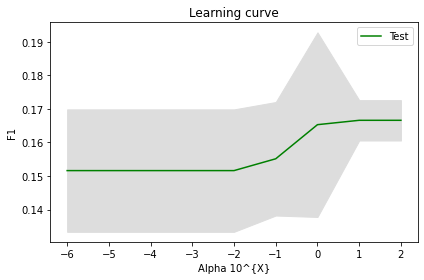

In [172]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [173]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.18784775558969108,
  0.5158670895667801,
  0.4935746606334842,
  0.5013452526146025,
  0.16529524637051518,
  0.16766777901371893,
  0.16766777901371893],
 [0.06633424444700753,
  0.0343070171358755,
  0.03097449228215081,
  0.039941565701260624,
  0.027500591002963325,
  0.004143150590694191,
  0.004143150590694191])

We proceed to draw the learning curve graph according to the data obtained by the training.

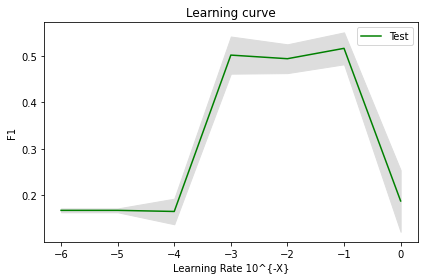

In [174]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [175]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [176]:
joblib.dump(mlp,"model_depression_i8.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

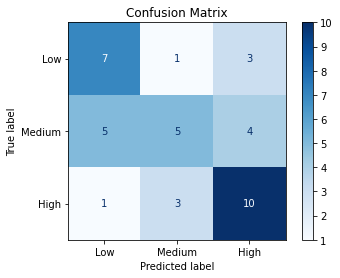

In [177]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [178]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 56.41025641025641 %

              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       0.56      0.36      0.43        14
           2       0.59      0.71      0.65        14

    accuracy                           0.56        39
   macro avg       0.56      0.57      0.55        39
weighted avg       0.56      0.56      0.55        39



In [179]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  1,2,3,4,5,7,9,11,12,14,15,16,18,19,21,23,24,25...        56.410256   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.538462  0.636364    0.583333         11     0.555556  0.357143   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.434783         14     0.588235  0.714286    0.645161         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [180]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

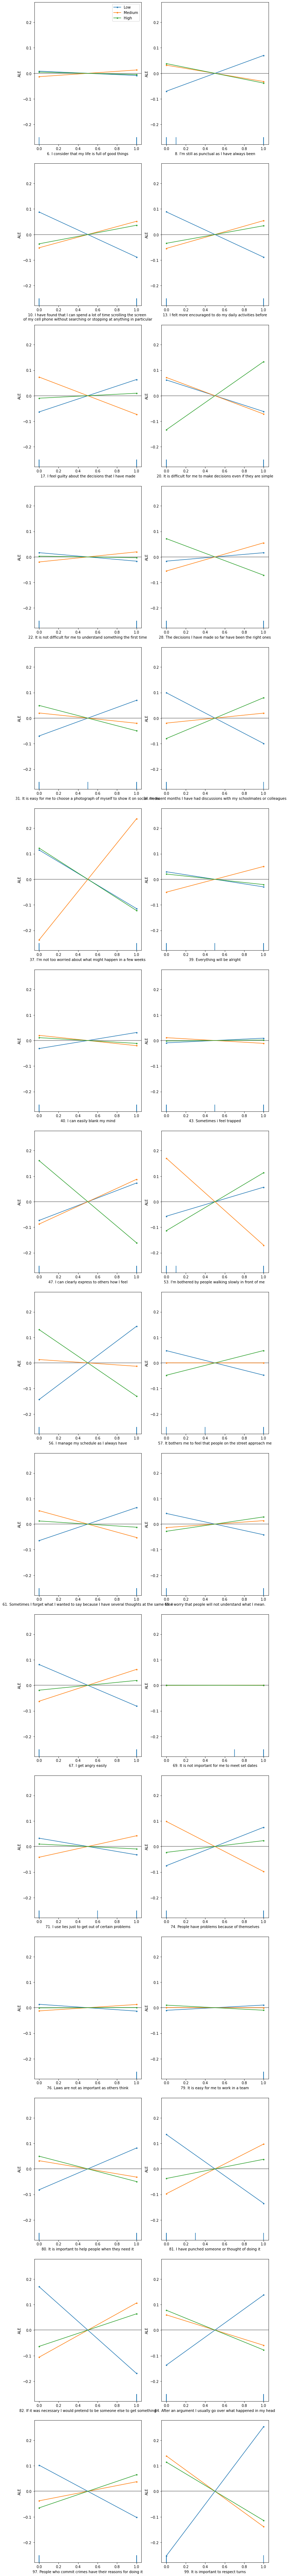

In [181]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [182]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6  -0.016898   -0.009221            NA             NA          NA   
1          8   0.140217   -0.076296            NA             NA          NA   
2         10  -0.176113    0.072612            NA             NA          NA   
3         13  -0.177525    0.068674            NA             NA          NA   
4         17   0.126749    0.019309            NA             NA          NA   
5         20  -0.123725    0.266977            NA             NA          NA   
6         22  -0.033232   -0.006150            NA             NA          NA   
7         28   0.032940   -0.143376            NA             NA          NA   
8         31   0.139452   -0.099286            NA             NA          NA   
9         34  -0.198799    0.159840            NA             NA          NA   
10        37  -0.229330   -0.244403            NA             NA          NA   
11        39  -0.059345   -0.041391            NA             NA          NA   
12        40   0.062790   -0.022374            NA             NA          NA   
13        43   0.018303    0.003914            NA             NA          NA   
14        47   0.146373   -0.321444            NA             NA          NA   
15        53   0.113668    0.227111            NA             NA          NA   
16        56   0.286560   -0.260347            NA             NA          NA   
17        57  -0.096207    0.096703            NA             NA          NA   
18        61   0.129353   -0.024400            NA             NA          NA   
19        65  -0.083473    0.056345            NA             NA          NA   
20        67  -0.162574    0.038037            NA             NA          NA   
21        69  -0.000428   -0.000305            NA             NA          NA   
22        71  -0.064951   -0.019088            NA             NA          NA   
23        74   0.150339    0.045915            NA             NA          NA   
24        76  -0.026505    0.001478            NA             NA          NA   
25        79   0.020513   -0.019847            NA             NA          NA   
26        80   0.163403   -0.099305            NA             NA          NA   
27        81  -0.269764    0.075097            NA             NA          NA   
28        82  -0.339421    0.127423            NA             NA          NA   
29        84   0.274748   -0.155498            NA             NA          NA   
30        97  -0.204237    0.129716            NA             NA          NA   
31        99   0.505799   -0.228619            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [183]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6  -0.016898   -0.009221             0             NA          NA   
1          8   0.140217   -0.076296             1              0          NA   
2         10  -0.176113    0.072612             0              1          NA   
3         13  -0.177525    0.068674             0              1          NA   
4         17   0.126749    0.019309             1              1          NA   
5         20  -0.123725    0.266977             0              1          NA   
6         22  -0.033232   -0.006150             0             NA          NA   
7         28   0.032940   -0.143376             1              0          NA   
8         31   0.139452   -0.099286             1              0          NA   
9         34  -0.198799    0.159840             0              1          NA   
10        37  -0.229330   -0.244403             0              0          NA   
11        39  -0.059345   -0.041391             0              0          NA   
12        40   0.062790   -0.022374             1              0          NA   
13        43   0.018303    0.003914             1             NA          NA   
14        47   0.146373   -0.321444             1              0          NA   
15        53   0.113668    0.227111             1              1          NA   
16        56   0.286560   -0.260347             1              0          NA   
17        57  -0.096207    0.096703             0              1          NA   
18        61   0.129353   -0.024400             1              0          NA   
19        65  -0.083473    0.056345             0              1          NA   
20        67  -0.162574    0.038037             0              1          NA   
21        69  -0.000428   -0.000305            NA             NA          NA   
22        71  -0.064951   -0.019088             0              0          NA   
23        74   0.150339    0.045915             1              1          NA   
24        76  -0.026505    0.001478             0             NA          NA   
25        79   0.020513   -0.019847             1              0          NA   
26        80   0.163403   -0.099305             1              0          NA   
27        81  -0.269764    0.075097             0              1          NA   
28        82  -0.339421    0.127423             0              1          NA   
29        84   0.274748   -0.155498             1              0          NA   
30        97  -0.204237    0.129716             0              1          NA   
31        99   0.505799   -0.228619             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [184]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        6   Considero que mi vida está llena de cosas buenas   0
1        8       Sigo siendo tan puntual como siempre he sido   0
2       10  Me he dado cuenta de que puedo pasar mucho tie...   1
3       13  Antes me sentía más animado para hacer mis act...   1
4       17    Siento culpa sobre las decisiones que he tomado   1
5       20  Me resulta complicado poder tomar decisiones a...   1
6       22      No se me dificulta entender algo a la primera   0
7       28  Las decisiones que he tomado hasta hoy han sid...   0
8       31  Me resulta fácil escoger una fotografía propia...   0
9       34  . En los últimos meses he tenido discusiones c...   1
10      37  No me preocupa tanto lo que pueda pasar en una...   0
11      39                                   Todo saldrá bien   0
12      40       Puedo poner mi mente en blanco con facilidad   0
13      43                         A veces me siento atrapado   1
14      47  Puedo expresarle con claridad a los otros cómo...   0
15      53  Me molesta la gente que camina lento por la ca...   1
16      56       Manejo mis horarios como siempre lo he hecho   0
17      57  Me incomoda sentir que la gente en la calle se...   1
18      61  A veces olvido lo que quería decir porque teng...   1
19      65  Me preocupa que la gente no entienda lo que qu...   1
20      67                             Me enojo con facilidad   1
21      69  No me resulta importante cumplir con fechas es...   1
22      71  Utilizo las mentiras sólo para salir de alguno...   1
23      74              La gente tiene problemas por su culpa   1
24      76  Las leyes no son tan importantes como otros creen   1
25      79                  Se me facilita trabajar en equipo   0
26      80  Es importante ayudar a la gente cuando lo nece...   0
27      81      He golpeado a alguien o he pensado en hacerlo   1
28      82  Si fuera necesario me haría pasar por alguien ...   1
29      84  Después de una discusión suelo repasar en mi c...   0
30      97  La gente que comete crímenes tiene sus razones...   1
31      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [185]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6  -0.016898   -0.009221             0             NA           1   
1          8   0.140217   -0.076296             1              0           0   
2         10  -0.176113    0.072612             0              1           0   
3         13  -0.177525    0.068674             0              1           0   
4         17   0.126749    0.019309             1              1           1   
5         20  -0.123725    0.266977             0              1           0   
6         22  -0.033232   -0.006150             0             NA           1   
7         28   0.032940   -0.143376             1              0           0   
8         31   0.139452   -0.099286             1              0           0   
9         34  -0.198799    0.159840             0              1           0   
10        37  -0.229330   -0.244403             0              0           1   
11        39  -0.059345   -0.041391             0              0           1   
12        40   0.062790   -0.022374             1              0           0   
13        43   0.018303    0.003914             1             NA           1   
14        47   0.146373   -0.321444             1              0           0   
15        53   0.113668    0.227111             1              1           1   
16        56   0.286560   -0.260347             1              0           0   
17        57  -0.096207    0.096703             0              1           0   
18        61   0.129353   -0.024400             1              0           1   
19        65  -0.083473    0.056345             0              1           0   
20        67  -0.162574    0.038037             0              1           0   
21        69  -0.000428   -0.000305            NA             NA          NA   
22        71  -0.064951   -0.019088             0              0           0   
23        74   0.150339    0.045915             1              1           1   
24        76  -0.026505    0.001478             0             NA           0   
25        79   0.020513   -0.019847             1              0           0   
26        80   0.163403   -0.099305             1              0           0   
27        81  -0.269764    0.075097             0              1           0   
28        82  -0.339421    0.127423             0              1           0   
29        84   0.274748   -0.155498             1              0           0   
30        97  -0.204237    0.129716             0              1           0   
31        99   0.505799   -0.228619             1              0           0   

   Anomaly High  
0            NA  
1             0  
2             0  
3             0  
4             0  
5             0  
6            NA  
7             0  
8             0  
9             0  
10            0  
11            0  
12            0  
13           NA  
14            0  
15            0  
16            0  
17            0  
18            1  
19            0  
20            0  
21           NA  
22            1  
23            0  
24           NA  
25            0  
26            0  
27            0  
28            0  
29            0  
30            0  
31            0

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [186]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[61, 71]

## Iteration 9

The ninth iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [187]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1                                                                                                 
100                                                  0                                                                                                 
101                                                  1                                                                                                 
102                                                  1                                                                                                 
103                                                  1                                                                                                 

     13. I felt more encouraged to do my daily activities before  \
0                                                    0             
1                                                    1             
2                                                    0             
3                                                    1             
4                                                    0             
..                                                 ...             
99                                                   1             
100                                                  1             
101                                                  1             
102                                                  0             
103                                                  0             

     

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [188]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [189]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [190]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [192]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.1632974910394265,
  0.18440860215053761,
  0.16659498207885304,
  0.16329749103942653,
  0.16329749103942653,
  0.16007168458781362,
  0.16007168458781362,
  0.16007168458781362,
  0.16007168458781362],
 [0.006619092595549127,
  0.03872527231332354,
  0.006020651927912844,
  0.006619092595549127,
  0.006619092595549127,
  0.007981170270805315,
  0.007981170270805315,
  0.007981170270805315,
  0.007981170270805315])

We proceed to draw the learning curve graph according to the data obtained by the training.

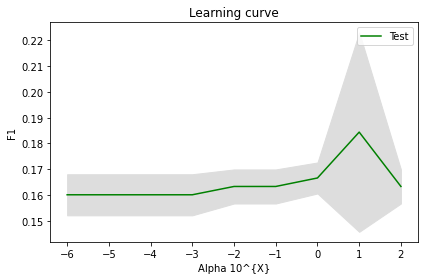

In [193]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [194]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.20310940326513185,
  0.48459609591188546,
  0.49239412634149476,
  0.4790273761326393,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.08155999298520603,
  0.04259588791679032,
  0.05868329640963389,
  0.039578941293398305,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

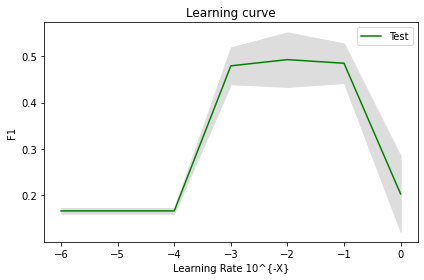

In [195]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [196]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [197]:
joblib.dump(mlp,"model_depression_i9.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

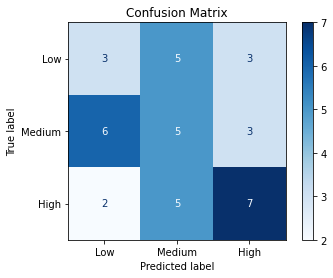

In [198]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [199]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 38.46153846153847 %

              precision    recall  f1-score   support

           0       0.27      0.27      0.27        11
           1       0.33      0.36      0.34        14
           2       0.54      0.50      0.52        14

    accuracy                           0.38        39
   macro avg       0.38      0.38      0.38        39
weighted avg       0.39      0.38      0.39        39



In [200]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  1,2,3,4,5,7,9,11,12,14,15,16,18,19,21,23,24,25...        38.461538   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.272727  0.272727    0.272727         11     0.333333  0.357143   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.344828         14     0.538462       0.5    0.518519         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [201]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

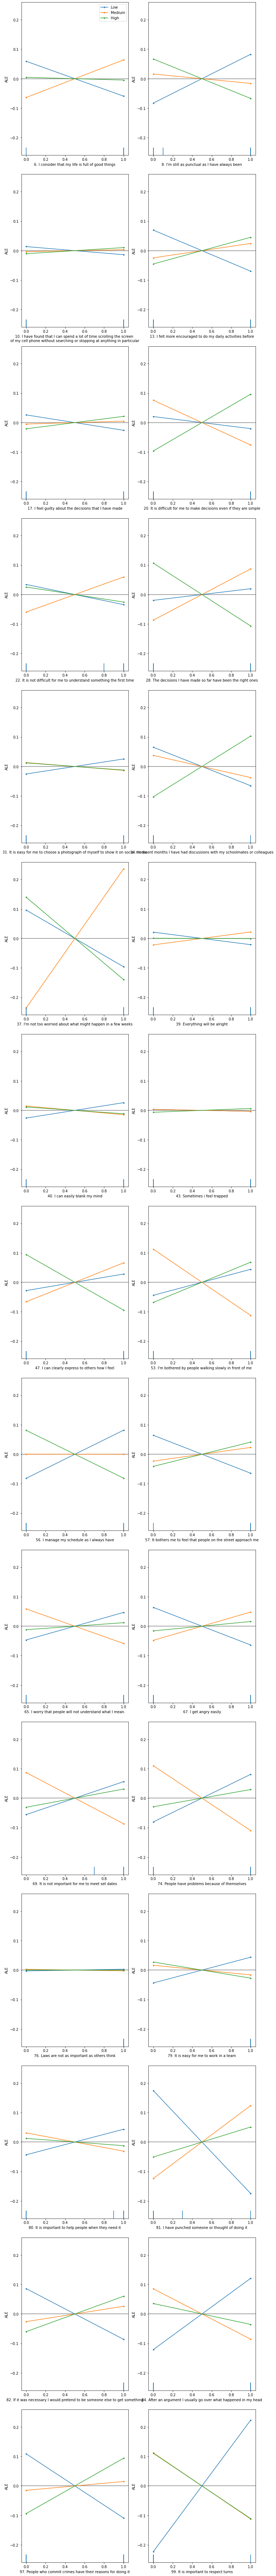

In [202]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [203]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6  -0.118198   -0.009232            NA             NA          NA   
1          8   0.165548   -0.133810            NA             NA          NA   
2         10  -0.027447    0.020734            NA             NA          NA   
3         13  -0.139358    0.090596            NA             NA          NA   
4         17  -0.052101    0.042164            NA             NA          NA   
5         20  -0.040889    0.192623            NA             NA          NA   
6         22  -0.068262   -0.050902            NA             NA          NA   
7         28   0.039451   -0.213099            NA             NA          NA   
8         31   0.050852   -0.024333            NA             NA          NA   
9         34  -0.130562    0.205781            NA             NA          NA   
10        37  -0.192314   -0.279125            NA             NA          NA   
11        39  -0.042490   -0.001309            NA             NA          NA   
12        40   0.052107   -0.022936            NA             NA          NA   
13        43  -0.006443    0.012856            NA             NA          NA   
14        47   0.056155   -0.188298            NA             NA          NA   
15        53   0.088198    0.136520            NA             NA          NA   
16        56   0.162849   -0.162200            NA             NA          NA   
17        57  -0.128730    0.082395            NA             NA          NA   
18        65   0.093418    0.023820            NA             NA          NA   
19        67  -0.127503    0.031653            NA             NA          NA   
20        69   0.111729    0.061799            NA             NA          NA   
21        74   0.161320    0.058544            NA             NA          NA   
22        76   0.005788   -0.000561            NA             NA          NA   
23        79   0.087194   -0.054662            NA             NA          NA   
24        80   0.086616   -0.024717            NA             NA          NA   
25        81  -0.348966    0.101760            NA             NA          NA   
26        82  -0.171888    0.119936            NA             NA          NA   
27        84   0.241688   -0.070825            NA             NA          NA   
28        97  -0.217495    0.187682            NA             NA          NA   
29        99   0.445895   -0.221588            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [204]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6  -0.118198   -0.009232             0             NA          NA   
1          8   0.165548   -0.133810             1              0          NA   
2         10  -0.027447    0.020734             0              1          NA   
3         13  -0.139358    0.090596             0              1          NA   
4         17  -0.052101    0.042164             0              1          NA   
5         20  -0.040889    0.192623             0              1          NA   
6         22  -0.068262   -0.050902             0              0          NA   
7         28   0.039451   -0.213099             1              0          NA   
8         31   0.050852   -0.024333             1              0          NA   
9         34  -0.130562    0.205781             0              1          NA   
10        37  -0.192314   -0.279125             0              0          NA   
11        39  -0.042490   -0.001309             0             NA          NA   
12        40   0.052107   -0.022936             1              0          NA   
13        43  -0.006443    0.012856            NA              1          NA   
14        47   0.056155   -0.188298             1              0          NA   
15        53   0.088198    0.136520             1              1          NA   
16        56   0.162849   -0.162200             1              0          NA   
17        57  -0.128730    0.082395             0              1          NA   
18        65   0.093418    0.023820             1              1          NA   
19        67  -0.127503    0.031653             0              1          NA   
20        69   0.111729    0.061799             1              1          NA   
21        74   0.161320    0.058544             1              1          NA   
22        76   0.005788   -0.000561            NA             NA          NA   
23        79   0.087194   -0.054662             1              0          NA   
24        80   0.086616   -0.024717             1              0          NA   
25        81  -0.348966    0.101760             0              1          NA   
26        82  -0.171888    0.119936             0              1          NA   
27        84   0.241688   -0.070825             1              0          NA   
28        97  -0.217495    0.187682             0              1          NA   
29        99   0.445895   -0.221588             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [205]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        6   Considero que mi vida está llena de cosas buenas   0
1        8       Sigo siendo tan puntual como siempre he sido   0
2       10  Me he dado cuenta de que puedo pasar mucho tie...   1
3       13  Antes me sentía más animado para hacer mis act...   1
4       17    Siento culpa sobre las decisiones que he tomado   1
5       20  Me resulta complicado poder tomar decisiones a...   1
6       22      No se me dificulta entender algo a la primera   0
7       28  Las decisiones que he tomado hasta hoy han sid...   0
8       31  Me resulta fácil escoger una fotografía propia...   0
9       34  . En los últimos meses he tenido discusiones c...   1
10      37  No me preocupa tanto lo que pueda pasar en una...   0
11      39                                   Todo saldrá bien   0
12      40       Puedo poner mi mente en blanco con facilidad   0
13      43                         A veces me siento atrapado   1
14      47  Puedo expresarle con claridad a los otros cómo...   0
15      53  Me molesta la gente que camina lento por la ca...   1
16      56       Manejo mis horarios como siempre lo he hecho   0
17      57  Me incomoda sentir que la gente en la calle se...   1
18      65  Me preocupa que la gente no entienda lo que qu...   1
19      67                             Me enojo con facilidad   1
20      69  No me resulta importante cumplir con fechas es...   1
21      74              La gente tiene problemas por su culpa   1
22      76  Las leyes no son tan importantes como otros creen   1
23      79                  Se me facilita trabajar en equipo   0
24      80  Es importante ayudar a la gente cuando lo nece...   0
25      81      He golpeado a alguien o he pensado en hacerlo   1
26      82  Si fuera necesario me haría pasar por alguien ...   1
27      84  Después de una discusión suelo repasar en mi c...   0
28      97  La gente que comete crímenes tiene sus razones...   1
29      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [206]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          6  -0.118198   -0.009232             0             NA           1   
1          8   0.165548   -0.133810             1              0           0   
2         10  -0.027447    0.020734             0              1           0   
3         13  -0.139358    0.090596             0              1           0   
4         17  -0.052101    0.042164             0              1           0   
5         20  -0.040889    0.192623             0              1           0   
6         22  -0.068262   -0.050902             0              0           1   
7         28   0.039451   -0.213099             1              0           0   
8         31   0.050852   -0.024333             1              0           0   
9         34  -0.130562    0.205781             0              1           0   
10        37  -0.192314   -0.279125             0              0           1   
11        39  -0.042490   -0.001309             0             NA           1   
12        40   0.052107   -0.022936             1              0           0   
13        43  -0.006443    0.012856            NA              1          NA   
14        47   0.056155   -0.188298             1              0           0   
15        53   0.088198    0.136520             1              1           1   
16        56   0.162849   -0.162200             1              0           0   
17        57  -0.128730    0.082395             0              1           0   
18        65   0.093418    0.023820             1              1           1   
19        67  -0.127503    0.031653             0              1           0   
20        69   0.111729    0.061799             1              1           1   
21        74   0.161320    0.058544             1              1           1   
22        76   0.005788   -0.000561            NA             NA          NA   
23        79   0.087194   -0.054662             1              0           0   
24        80   0.086616   -0.024717             1              0           0   
25        81  -0.348966    0.101760             0              1           0   
26        82  -0.171888    0.119936             0              1           0   
27        84   0.241688   -0.070825             1              0           0   
28        97  -0.217495    0.187682             0              1           0   
29        99   0.445895   -0.221588             1              0           0   

   Anomaly High  
0            NA  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11           NA  
12            0  
13            0  
14            0  
15            0  
16            0  
17            0  
18            0  
19            0  
20            0  
21            0  
22           NA  
23            0  
24            0  
25            0  
26            0  
27            0  
28            0  
29            0

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [207]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[]